# Analytics - query to reference mapping  

This notebook is based on and adapted from this scvi-tools tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/query_hlca_knn.html

In [5]:
import os
os.environ['R_HOME'] = '/home/cane/miniconda3/envs/resolvi/lib/R'
import milopy

In [6]:
import scvi
import mplscience
import matplotlib.pyplot as plt
import os
import pynndescent
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scvi.data._download import _download
import anndata

scvi.settings.seed = 1

# plotting commands for the styling
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

Global seed set to 1


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Citations

scArches:  
Mohammad Lotfollahi, Mohsen Naghipourfar, Malte D. Luecken, Matin Khajavi, Maren Büttner, Marco Wagenstetter, Žiga Avsec, Adam Gayoso, Nir Yosef, Marta Interlandi, Sergei Rybakov, Alexander V. Misharin, and Fabian J. Theis. Mapping single-cell data to reference atlases by transfer learning. Nature Biotechnology, 40(1):121–130, August 2021. doi:10.1038/s41587-021-01001-7.  

scANVI:  
Chenling Xu, Romain Lopez, Edouard Mehlman, Jeffrey Regier, Michael I Jordan, and Nir Yosef. Probabilistic harmonization and annotation of single-cell transcriptomics data with deep generative models. Molecular Systems Biology, January 2021. doi:10.15252/msb.20209620.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

In [7]:
local_dir = "/home/cane/Documents/yoseflab/can/scvi-hub/scvi-hub-reproducibility"

## 1️⃣ Download the pre-trained model

Here we use the HLCA dataset.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

Let's download the pre-trained model

In [4]:
model_url = "https://huggingface.co/scvi-tools/human-lung-cell-atlas/resolve/main/model.pt"
_download(model_url, local_dir, "model.pt")

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/scvi-hub-reproducibility/model.pt already downloaded      


## 2️⃣ Download the query data

For the query, we will use samples from the following publication:  

- Dysregulated lung stroma drives emphysema exacerbation by potentiating resident lymphocytes to suppress an epithelial stem cell reservoir

    Chaoqun Wang
    Ben Hyams
    Nancy C. Allen
    Paul Wolters
    Ari B. Molofsky
    Tien Peng 6


In [5]:
from scvi.data import cellxgene

adata_url = "https://cellxgene.cziscience.com/e/1e5bd3b8-6a0e-4959-8d69-cafed30fe814.cxg/"
adata_immune = cellxgene(adata_url, filename="emphysema_immune.h5ad", save_path=local_dir)
adata_url = "https://cellxgene.cziscience.com/e/4b6af54a-4a21-46e0-bc8d-673c0561a836.cxg/"
adata_nonimmune = cellxgene(adata_url, filename="emphysema_nonimmune.h5ad", save_path=local_dir)
adata_url = "https://cellxgene.cziscience.com/e/214bf9eb-93db-48c8-8e3c-9bb22fa3bc63.cxg/"
adata_at2 = cellxgene(adata_url, filename="emphysema_at2.h5ad", save_path=local_dir)

In [6]:
adata_nonimmune[np.intersect1d(adata_nonimmune.obs_names, adata_at2.obs_names)].obs['celltype'] = adata_at2[np.intersect1d(adata_nonimmune.obs_names, adata_at2.obs_names)].obs['celltype']

/tmp/ipykernel_466915/53203445.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nonimmune[np.intersect1d(adata_nonimmune.obs_names, adata_at2.obs_names)].obs['celltype'] = adata_at2[np.intersect1d(adata_nonimmune.obs_names, adata_at2.obs_names)].obs['celltype']


In [7]:
query_data = anndata.concat([adata_immune, adata_nonimmune], join='outer', label='compartment', keys=['immune', 'nonimmune'])
query_data.var = adata_nonimmune.var

In [8]:
query_data.X = query_data.raw.X
query_data.X.data

array([ 1.,  2.,  1., ..., 24.,  2., 83.], dtype=float32)

In [9]:
query_data.obs['dataset'] = 'emphysema'

## 3️⃣ Build a query model

Use `prepare_query_anndata` to re-order the genes and pad any missing genes with 0s, so that query_adata matches exactly the reference in terms of its gene set.  

In [10]:
scvi.model.SCANVI.prepare_query_anndata(query_data, local_dir)

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/scvi-hub-reproducibility/model.pt already downloaded      
INFO     Found 98.5% reference vars in query data.                                                                 


/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/anndata/_core/merge.py:1337: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [11]:
query_data.obs["scanvi_label"] = "unlabeled"

In [12]:
query_model = scvi.model.SCANVI.load_query_data(query_data, local_dir, accelerator = "cpu")

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/scvi-hub-reproducibility/model.pt already downloaded      


/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [13]:
query_model.adata

AnnData object with n_obs × n_vars = 54085 × 2000
    obs: 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'celltype', 'organism_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'compartment', 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels'
    var: 'name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'

Train the query model.

In [14]:
surgery_epochs = 200
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [15]:
query_model.train(
    max_epochs=surgery_epochs,
    accelerator="cuda",
    **train_kwargs_surgery,
)

INFO     Training for 200 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 107/200:  54%|█████▎    | 107/200 [03:50<03:20,  2.15s/it, v_num=1, train_loss_step=857, train_loss_epoch=874]  
Monitored metric elbo_train did not improve in the last 10 records. Best score: 948.408. Signaling Trainer to stop.


In [16]:
query_data.obsm['X_scanvi_emb'] = query_model.get_latent_representation()

In [17]:
query_save_path = f"{local_dir}/query_model"
query_model.save(query_save_path, overwrite=True)
query_data.write(f"{local_dir}/query_data_emphysema.h5ad")

## 4️⃣ Learn a neighbors index on reference latent space  

Get the "latent space" from our embeddings. It is essentially just the mean of the latent distribution.

In [18]:
fname = "HLCA_full_v1.1_emb.h5ad"
adata = sc.read(os.path.join(local_dir, fname), backup_url=f"https://zenodo.org/record/7599104/files/{fname}")
adata = adata[adata.obs["core_or_extension"] == "core"].copy()

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [19]:
from scvi.data import cellxgene

adata_url = "https://cellxgene.cziscience.com/e/9f222629-9e39-47d0-b83f-e08d610c7479.cxg/"
adata = cellxgene(adata_url, filename="adata_full.h5ad", save_path=local_dir)

In [20]:
pd.options.display.max_rows = 1000

In [21]:
labeled_adata = adata[adata.obs['ann_finest_level']!='Unknown']

## 5️⃣ Predict cell types

Let's predict using a different cell type than we did earlier, as that is too coarse grained (compartment-level resolution).

In [22]:
ref_nn_index = pynndescent.NNDescent(labeled_adata.obsm['X_scanvi_emb'])
ref_nn_index.prepare()

In [23]:
ref_neighbors, ref_distances = ref_nn_index.query(query_data.obsm['X_scanvi_emb'])

In [24]:
def distances_to_affinities(distances):
    # convert distances to affinities
    stds = np.std(distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)
    distances_tilda = np.exp(-np.true_divide(distances, stds))
    weights = distances_tilda / np.sum(
        distances_tilda, axis=1, keepdims=True
    )
    return weights

# import numba
# @numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

weights = distances_to_affinities(ref_distances)

### Predict

In [25]:
label_key = "ann_finest_level"
ref_cats = labeled_adata.obs[label_key].cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(labeled_adata.obs[label_key].cat.categories)[p]

query_data.obs["celltype_pred"], query_data.obs["celltype_uncertainty"] = p, u

In [26]:
pd.options.display.max_rows = 1000

### Evaluate predictions

Finally, let's evaluate predictions.

In [27]:
query_data.obs[["celltype_pred", "celltype_uncertainty"]]

celltype_pred  celltype_uncertainty
index                                                                
AAACCCAAGCGTTCAT-1_1                CD8 T cells          0.000000e+00
AAACCCAGTCCTCCAT-1_1                CD4 T cells          5.960464e-08
AAACCCAGTCGCATGC-1_1        Classical monocytes          0.000000e+00
AAACCCATCAAACGTC-1_1                CD4 T cells          0.000000e+00
AAACGAAAGCACGATG-1_1        Classical monocytes          0.000000e+00
...                                         ...                   ...
TTTGGTTGTACGTGAG-1_6       Alveolar fibroblasts          0.000000e+00
TTTGGTTGTAGCTCGC-1_6                        AT2          0.000000e+00
TTTGGTTTCTATACGG-1_6                  Pericytes          0.000000e+00
TTTGTTGAGAGCAACC-1_6  Peribronchial fibroblasts          2.999714e-01
TTTGTTGCACTTGGCG-1_6         EC venous systemic          5.960464e-08

[54085 rows x 2 columns]

0.06056932175050351 1.1920928955078125e-07


<Axes: ylabel='Density'>

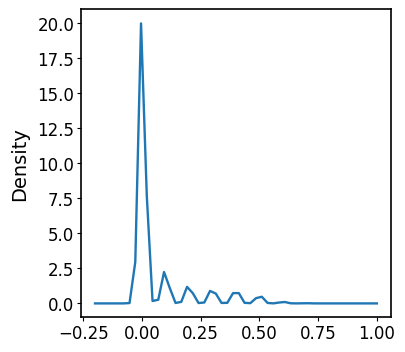

In [28]:
print(query_data.obs["celltype_uncertainty"].mean(), np.quantile(query_data.obs["celltype_uncertainty"], 0.75))
query_data.obs["celltype_uncertainty"].plot(kind='density', ind=np.linspace(-0.2, 1))

In [29]:
query_data.obs

donor_id  nCount_RNA  nFeature_RNA  percent.mt  \
index                                                                 
AAACCCAAGCGTTCAT-1_1      NL1      2064.0           978    8.624031   
AAACCCAGTCCTCCAT-1_1      NL1      2084.0          1106    7.869482   
AAACCCAGTCGCATGC-1_1      NL1     16808.0          3587    5.021418   
AAACCCATCAAACGTC-1_1      NL1      2377.0          1001    7.824989   
AAACGAAAGCACGATG-1_1      NL1      9414.0          2704    9.400892   
...                       ...         ...           ...         ...   
TTTGGTTGTACGTGAG-1_6     Emp3     18680.0          4631    4.014989   
TTTGGTTGTAGCTCGC-1_6     Emp3     15115.0          3189    9.646047   
TTTGGTTTCTATACGG-1_6     Emp3      5297.0          2375    4.172173   
TTTGTTGAGAGCAACC-1_6     Emp3     11294.0          3839    6.658403   
TTTGTTGCACTTGGCG-1_6     Emp3     12394.0          3497    5.930289   

                     seurat_clusters             celltype  \
index                                                       
AAACCCAAGCGTTCAT-1_1               1               T cell   
AAACCCAGTCCTCCAT-1_1               0               T cell   
AAACCCAGTCGCATGC-1_1               2             Monocyte   
AAACCCATCAAACGTC-1_1               0               T cell   
AAACGAAAGCACGATG-1_1               4             Monocyte   
...                              ...                  ...   
TTTGGTTGTACGTGAG-1_6               3  Proximal fibroblast   
TTTGGTTGTAGCTCGC-1_6               0                  AT2   
TTTGGTTTCTATACGG-1_6              13             Pericyte   
TTTGTTGAGAGCAACC-1_6               1    Distal fibroblast   
TTTGTTGCACTTGGCG-1_6               4          Endothelial   

                     organism_ontology_term_id assay_ontology_term_id  \
index                                                                   
AAACCCAAGCGTTCAT-1_1            NCBITaxon:9606            EFO:0009922   
AAACCCAGTCCTCCAT-1_1            NCBITaxon:9606            EFO:0009922   
AAACCCAGTCGCATGC-1_1            NCBITaxon:9606            EFO:0009922   
AAACCCATCAAACGTC-1_1            NCBITaxon:9606            EFO:0009922   
AAACGAAAGCACGATG-1_1            NCBITaxon:9606            EFO:0009922   
...                                        ...                    ...   
TTTGGTTGTACGTGAG-1_6            NCBITaxon:9606            EFO:0009922   
TTTGGTTGTAGCTCGC-1_6            NCBITaxon:9606            EFO:0009922   
TTTGGTTTCTATACGG-1_6            NCBITaxon:9606            EFO:0009922   
TTTGTTGAGAGCAACC-1_6            NCBITaxon:9606            EFO:0009922   
TTTGTTGCACTTGGCG-1_6            NCBITaxon:9606            EFO:0009922   

                     self_reported_ethnicity_ontology_term_id  \
index                                                           
AAACCCAAGCGTTCAT-1_1                           HANCESTRO:0005   
AAACCCAGTCCTCCAT-1_1                           HANCESTRO:0005   
AAACCCAGTCGCATGC-1_1                           HANCESTRO:0005   
AAACCCATCAAACGTC-1_1                           HANCESTRO:0005   
AAACGAAAGCACGATG-1_1                           HANCESTRO:0005   
...                                                       ...   
TTTGGTTGTACGTGAG-1_6                                  unknown   
TTTGGTTGTAGCTCGC-1_6                                  unknown   
TTTGGTTTCTATACGG-1_6                                  unknown   
TTTGTTGAGAGCAACC-1_6                                  unknown   
TTTGTTGCACTTGGCG-1_6                                  unknown   

                     tissue_ontology_term_id  ...            tissue  \
index                                         ...                     
AAACCCAAGCGTTCAT-1_1          UBERON:0002299  ...  alveolus of lung   
AAACCCAGTCCTCCAT-1_1          UBERON:0002299  ...  alveolus of lung   
AAACCCAGTCGCATGC-1_1          UBERON:0002299  ...  alveolus of lung   
AAACCCATCAAACGTC-1_1          UBERON:0002299  ...  alveolus of lung   
AAACGAAAGCACGATG-1_1          UBERON:0002299  ...  alveolus of lung   
...       

In [30]:
def get_comparison_df(uncertainty_threshold = None):
    # build comparison_df
    comparison_df = pd.DataFrame(index=query_data.obs.index, columns=["pred", "ground_truth", "pred_uncertainty"])
    comparison_df["pred"] = query_data.obs["celltype_pred"]
    comparison_df["pred_uncertainty"] = query_data.obs["celltype_uncertainty"]
    comparison_df["ground_truth"] = query_data.obs["celltype"].astype(str).fillna("Unknown")

    # we dont care about cases where we dont know the ground truth (in fact we could have skipped prediction for these altogether)
    n_before = len(comparison_df)
    comparison_df = comparison_df[comparison_df["ground_truth"] != "nan"]
    n_filtered = n_before-len(comparison_df)
    pct_filtered = 100*n_filtered/n_before
    print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with unknown ground truth")

    if uncertainty_threshold is not None:
        # filter out uncertainty > threshold
        n_before = len(comparison_df)
        comparison_df = comparison_df[comparison_df["pred_uncertainty"] <= uncertainty_threshold]
        n_filtered = n_before-len(comparison_df)
        pct_filtered = 100*n_filtered/n_before
        print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with pred uncertainty > {uncertainty_threshold}")

    return comparison_df

In [31]:
comparison_df = get_comparison_df(uncertainty_threshold=0.4)

filtered out 0 barcodes (0.00%) with unknown ground truth
filtered out 2432 barcodes (4.50%) with pred uncertainty > 0.4


## 6️⃣ Plot
Let's plot heatmap

In [32]:
temp_fig_dir = "/home/cane/Documents/yoseflab/can/scvi-hub/query_ref/"

In [33]:
# https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cellassign_tutorial.html#Model-reproducibility
confusion_matrix = pd.crosstab(
    comparison_df["pred"],
    comparison_df["ground_truth"], 
    rownames=["Predicted label"],
    colnames=["True label"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
confusion_matrix *= 100

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _prediction_eval(
    pred,
    labels,
    name,
    x_label="",
    y_label="",
    save_fig=None,
):
    """Generate confusion matrix."""
    types, _ = np.unique(np.concatenate([labels, pred]), return_inverse=True)
    mtx = confusion_matrix(labels, pred, normalize="true")
    df = pd.DataFrame(mtx, columns=types, index=types)
    df = df.loc[np.unique(labels), np.unique(pred)]
    df = df.rename_axis(x_label, axis="columns")
    df = df.rename_axis(y_label)
    #df = df[df.idxmax(axis=1).unique()]
    df = df[pred.value_counts().index]
    positions = [df.columns.get_loc(index) for index in df.idxmax(axis=1)]
    df = df.loc[df.index[np.argsort(positions)]]
    fig, ax = plt.subplots(figsize=[15, 15])
    sns.heatmap(df.T, linewidths=0.005, cmap="OrRd", square=True)
    plt.tight_layout()
    plt.title(name)
    plt.xlabel('PopV prediction')
    plt.ylabel('Original Annotation')

    if save_fig:
        plt.savefig(save_fig)
    plt.show()
    
    return df

In [35]:
comparison_df.loc[comparison_df["pred"].isin(comparison_df["pred"].value_counts()[comparison_df["pred"].value_counts()<10].index), "pred"] = "Other"

In [36]:
comparison_df.loc[comparison_df["pred"].isin(comparison_df["pred"].value_counts()[comparison_df["pred"].value_counts()<10].index), "pred"]

Series([], Name: pred, dtype: object)

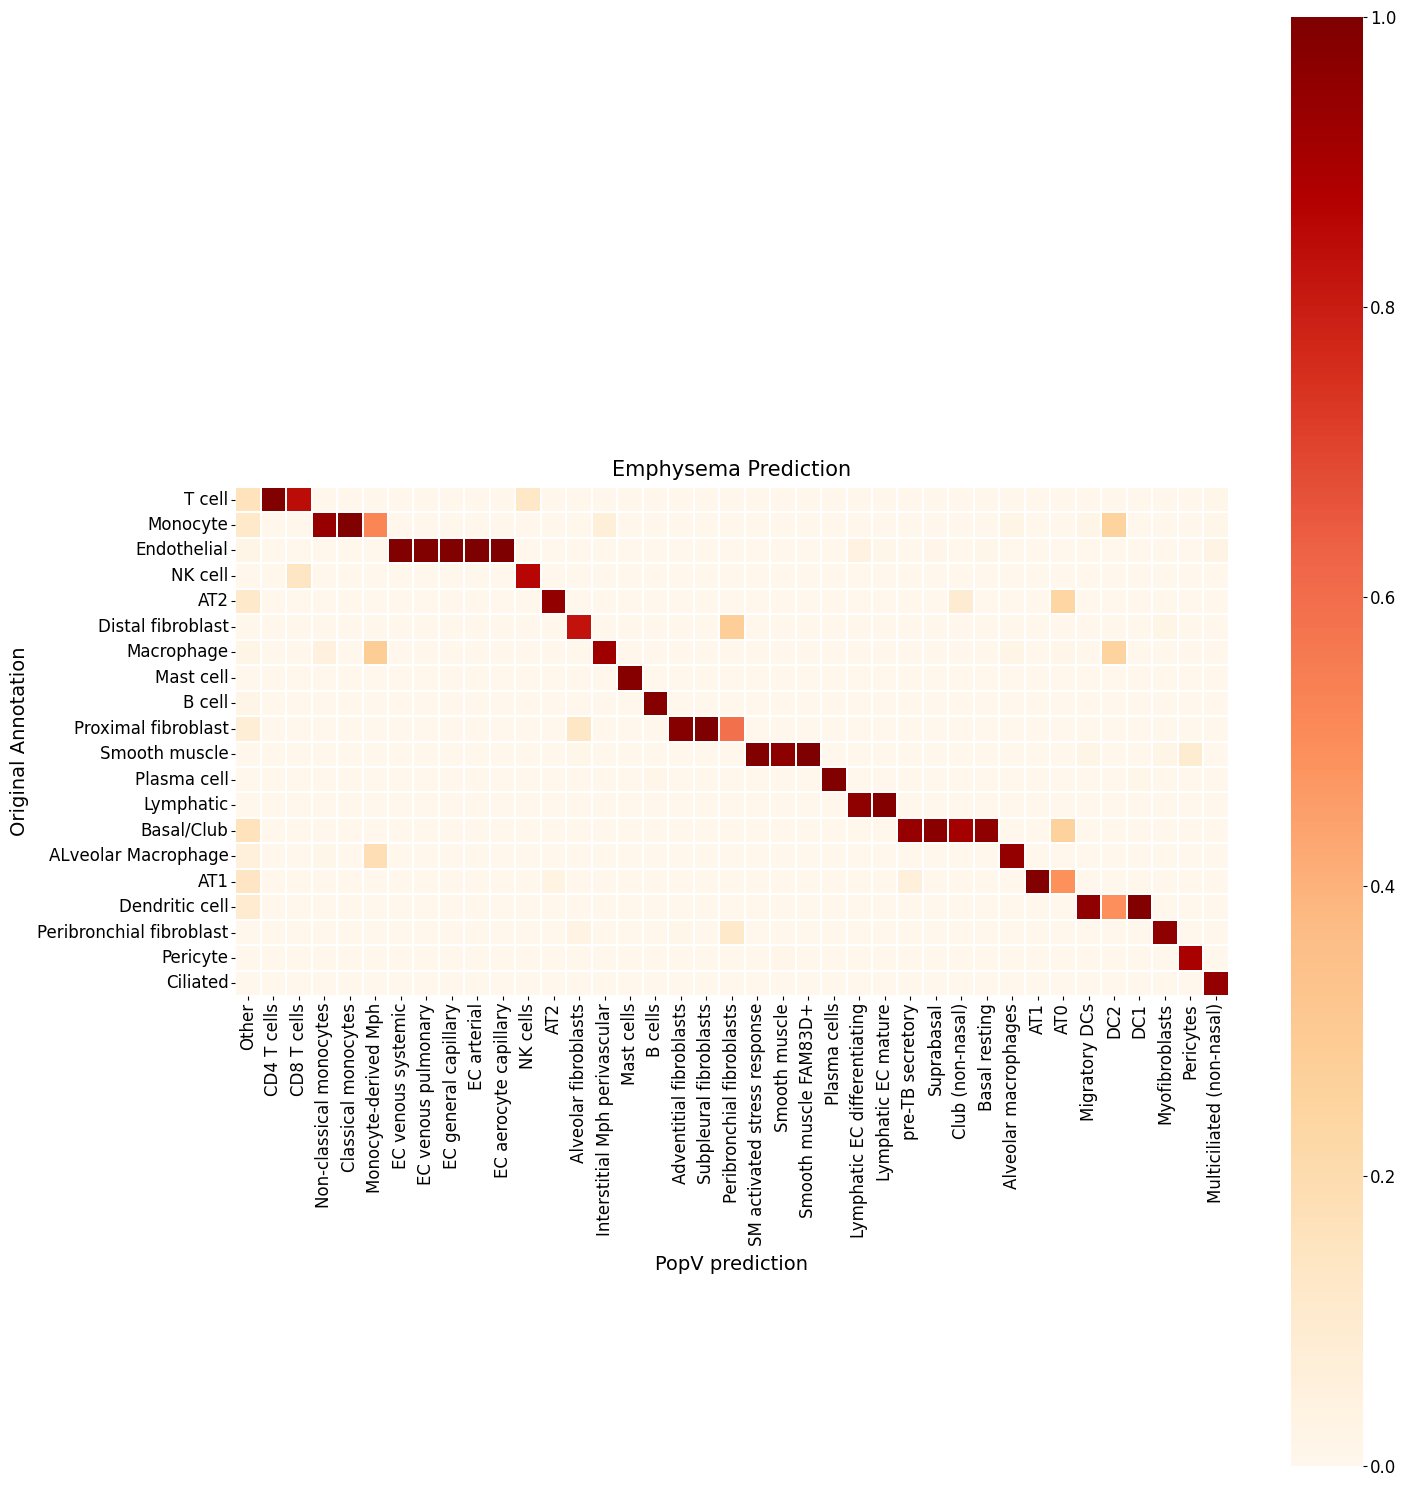

In [37]:
_ = _prediction_eval(
    pred=comparison_df["ground_truth"],
    labels=comparison_df["pred"],
    name='Emphysema Prediction',
    x_label=["Predicted label"],
    y_label=["True label"],
    save_fig=f"figures/emphysema_celltype_prediction.pdf",
)

Some notes on the new HLCA annotations (https://zenodo.org/record/6337966/ vs https://zenodo.org/record/7599104):
- All new 60 cells have None for ann_level_3 annotations.
- No cells was predicted as "Smooth muscle FAM83D+" (even before thresholding on prediction uncertainty)
- In prev ann_level_3, not in new: 'Fibromyocytes'
- In new ann_level_3, not in prev: 'Smooth muscle FAM83D+'
- Only 565 cells differ between prev and new ann_level_3 annotations and their distribution is (prev, new):  
Fibromyocytes,Smooth muscle FAM83D+   -> 335  
Secretory,AT2                       ->   230

In [38]:
len(comparison_df["ground_truth"].astype("category").cat.categories), len(comparison_df["pred"].astype("category").cat.categories)

(20, 39)

## 7️⃣ Visualize embeddings in the joint latent space

Combine embeddings

In [39]:
combined_adata = adata.concatenate(query_data, join='inner')
combined_adata.obs

sc.pp.neighbors(combined_adata, n_neighbors=30, use_rep="X_scanvi_emb", method='rapids')
sc.tl.umap(combined_adata, min_dist=0.3, method='rapids')

/tmp/ipykernel_466915/667177593.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = adata.concatenate(query_data, join='inner')


/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/anndata/_core/merge.py:1337: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/cudf/utils/_numba.py:110: UserWarning: Using CUDA toolkit version (12, 1) with CUDA driver version (12, 0) requires minor version compatibility, which is not yet supported for CUDA driver versions 12.0 and above. It is likely that many cuDF operations will not work in this state. Please install CUDA toolkit version (12, 0) to continue using cuDF.
  warnings.warn(


Visualize embeddings.

I do this on a device with more ram, but you can run it locally if you have enough ram.

In [40]:
combined_adata.write_h5ad(f"{local_dir}/combined_adata_emphysema.h5ad")

## 8 Visualize embeddings in the joint latent space

Display embeddings

In [8]:
sc.set_figure_params(vector_friendly=True, dpi_save=300)

In [9]:
combined_adata = sc.read(f"{local_dir}/combined_adata_emphysema.h5ad")

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


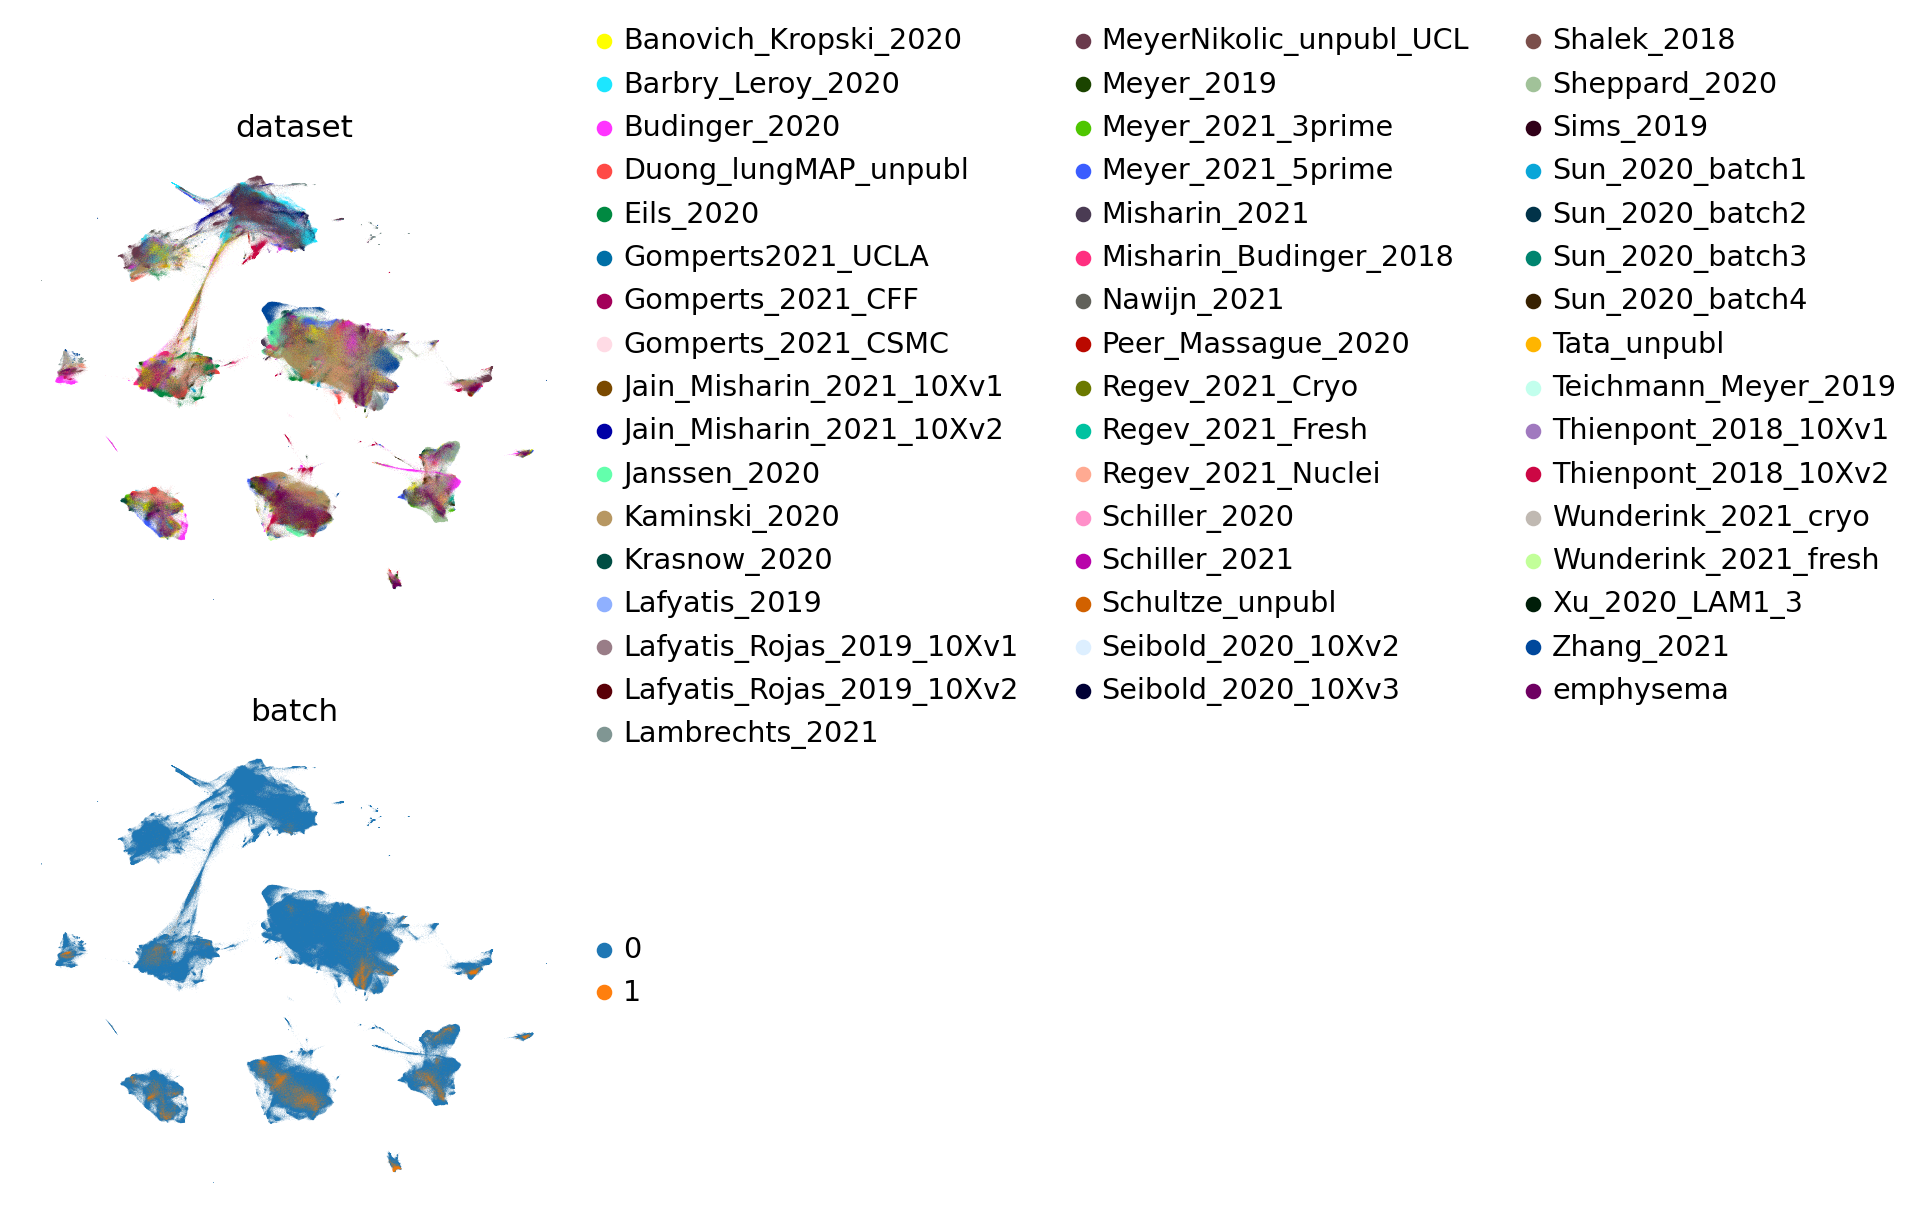

In [43]:
sc.pl.umap(
    combined_adata,
    color=["dataset", "batch"],
    ncols=1,
    frameon=False,
)

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


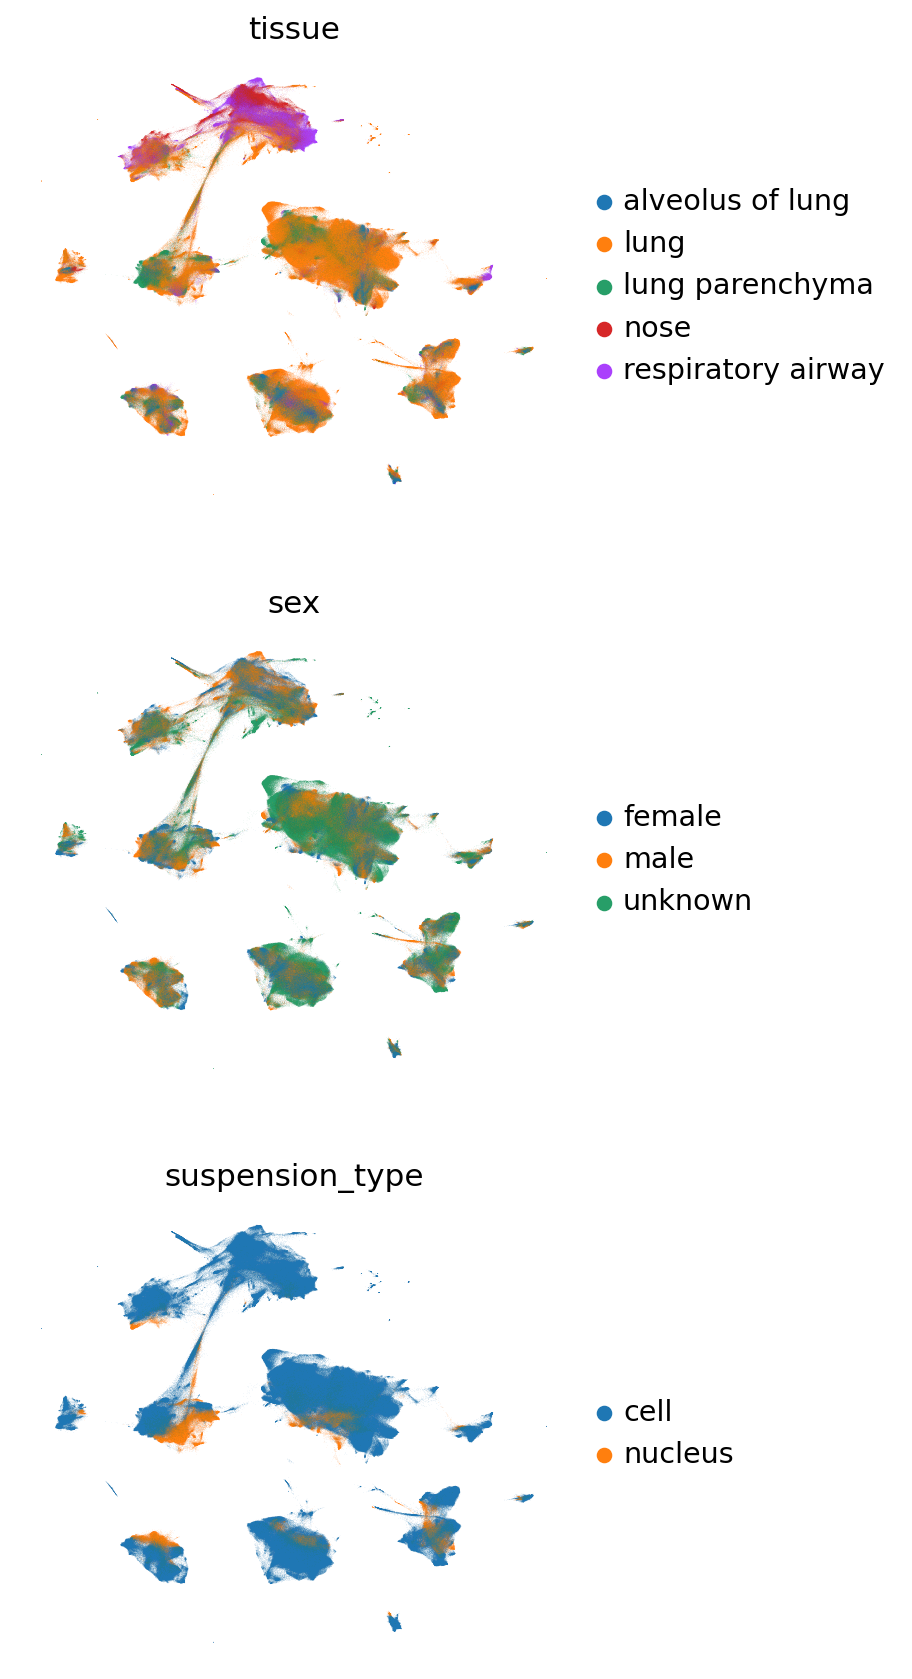

In [44]:
sc.pl.umap(
    combined_adata,
    color=["tissue", "sex", "suspension_type"],
    ncols=1,
    frameon=False,
)

Let's plot only batch. It is 1:1 equivalent with the dataset anyway as can be seen below.

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


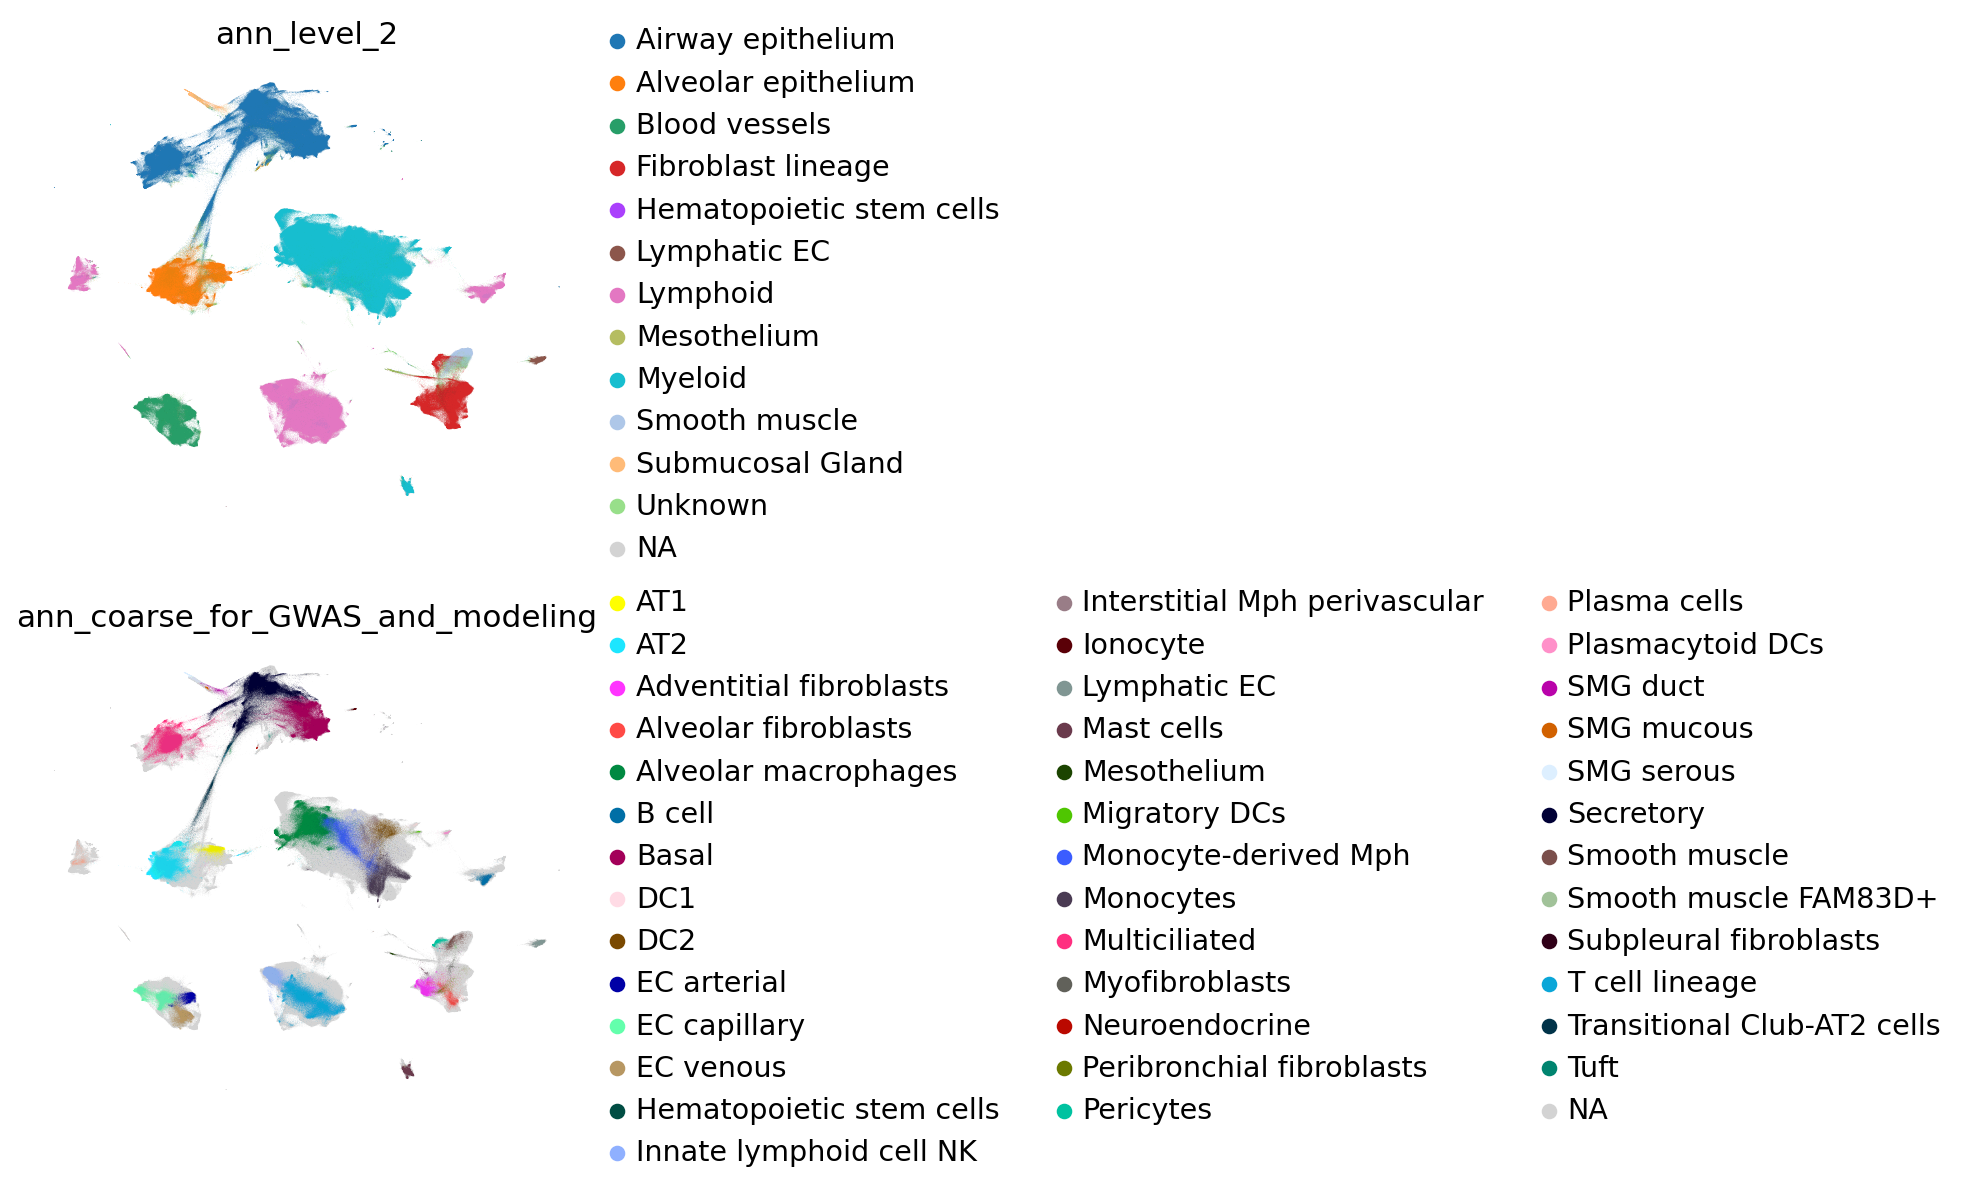

In [45]:
sc.pl.umap(
    combined_adata,
    color=["ann_level_2", "ann_coarse_for_GWAS_and_modeling"],
    ncols=1,
    frameon=False,
)

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tool

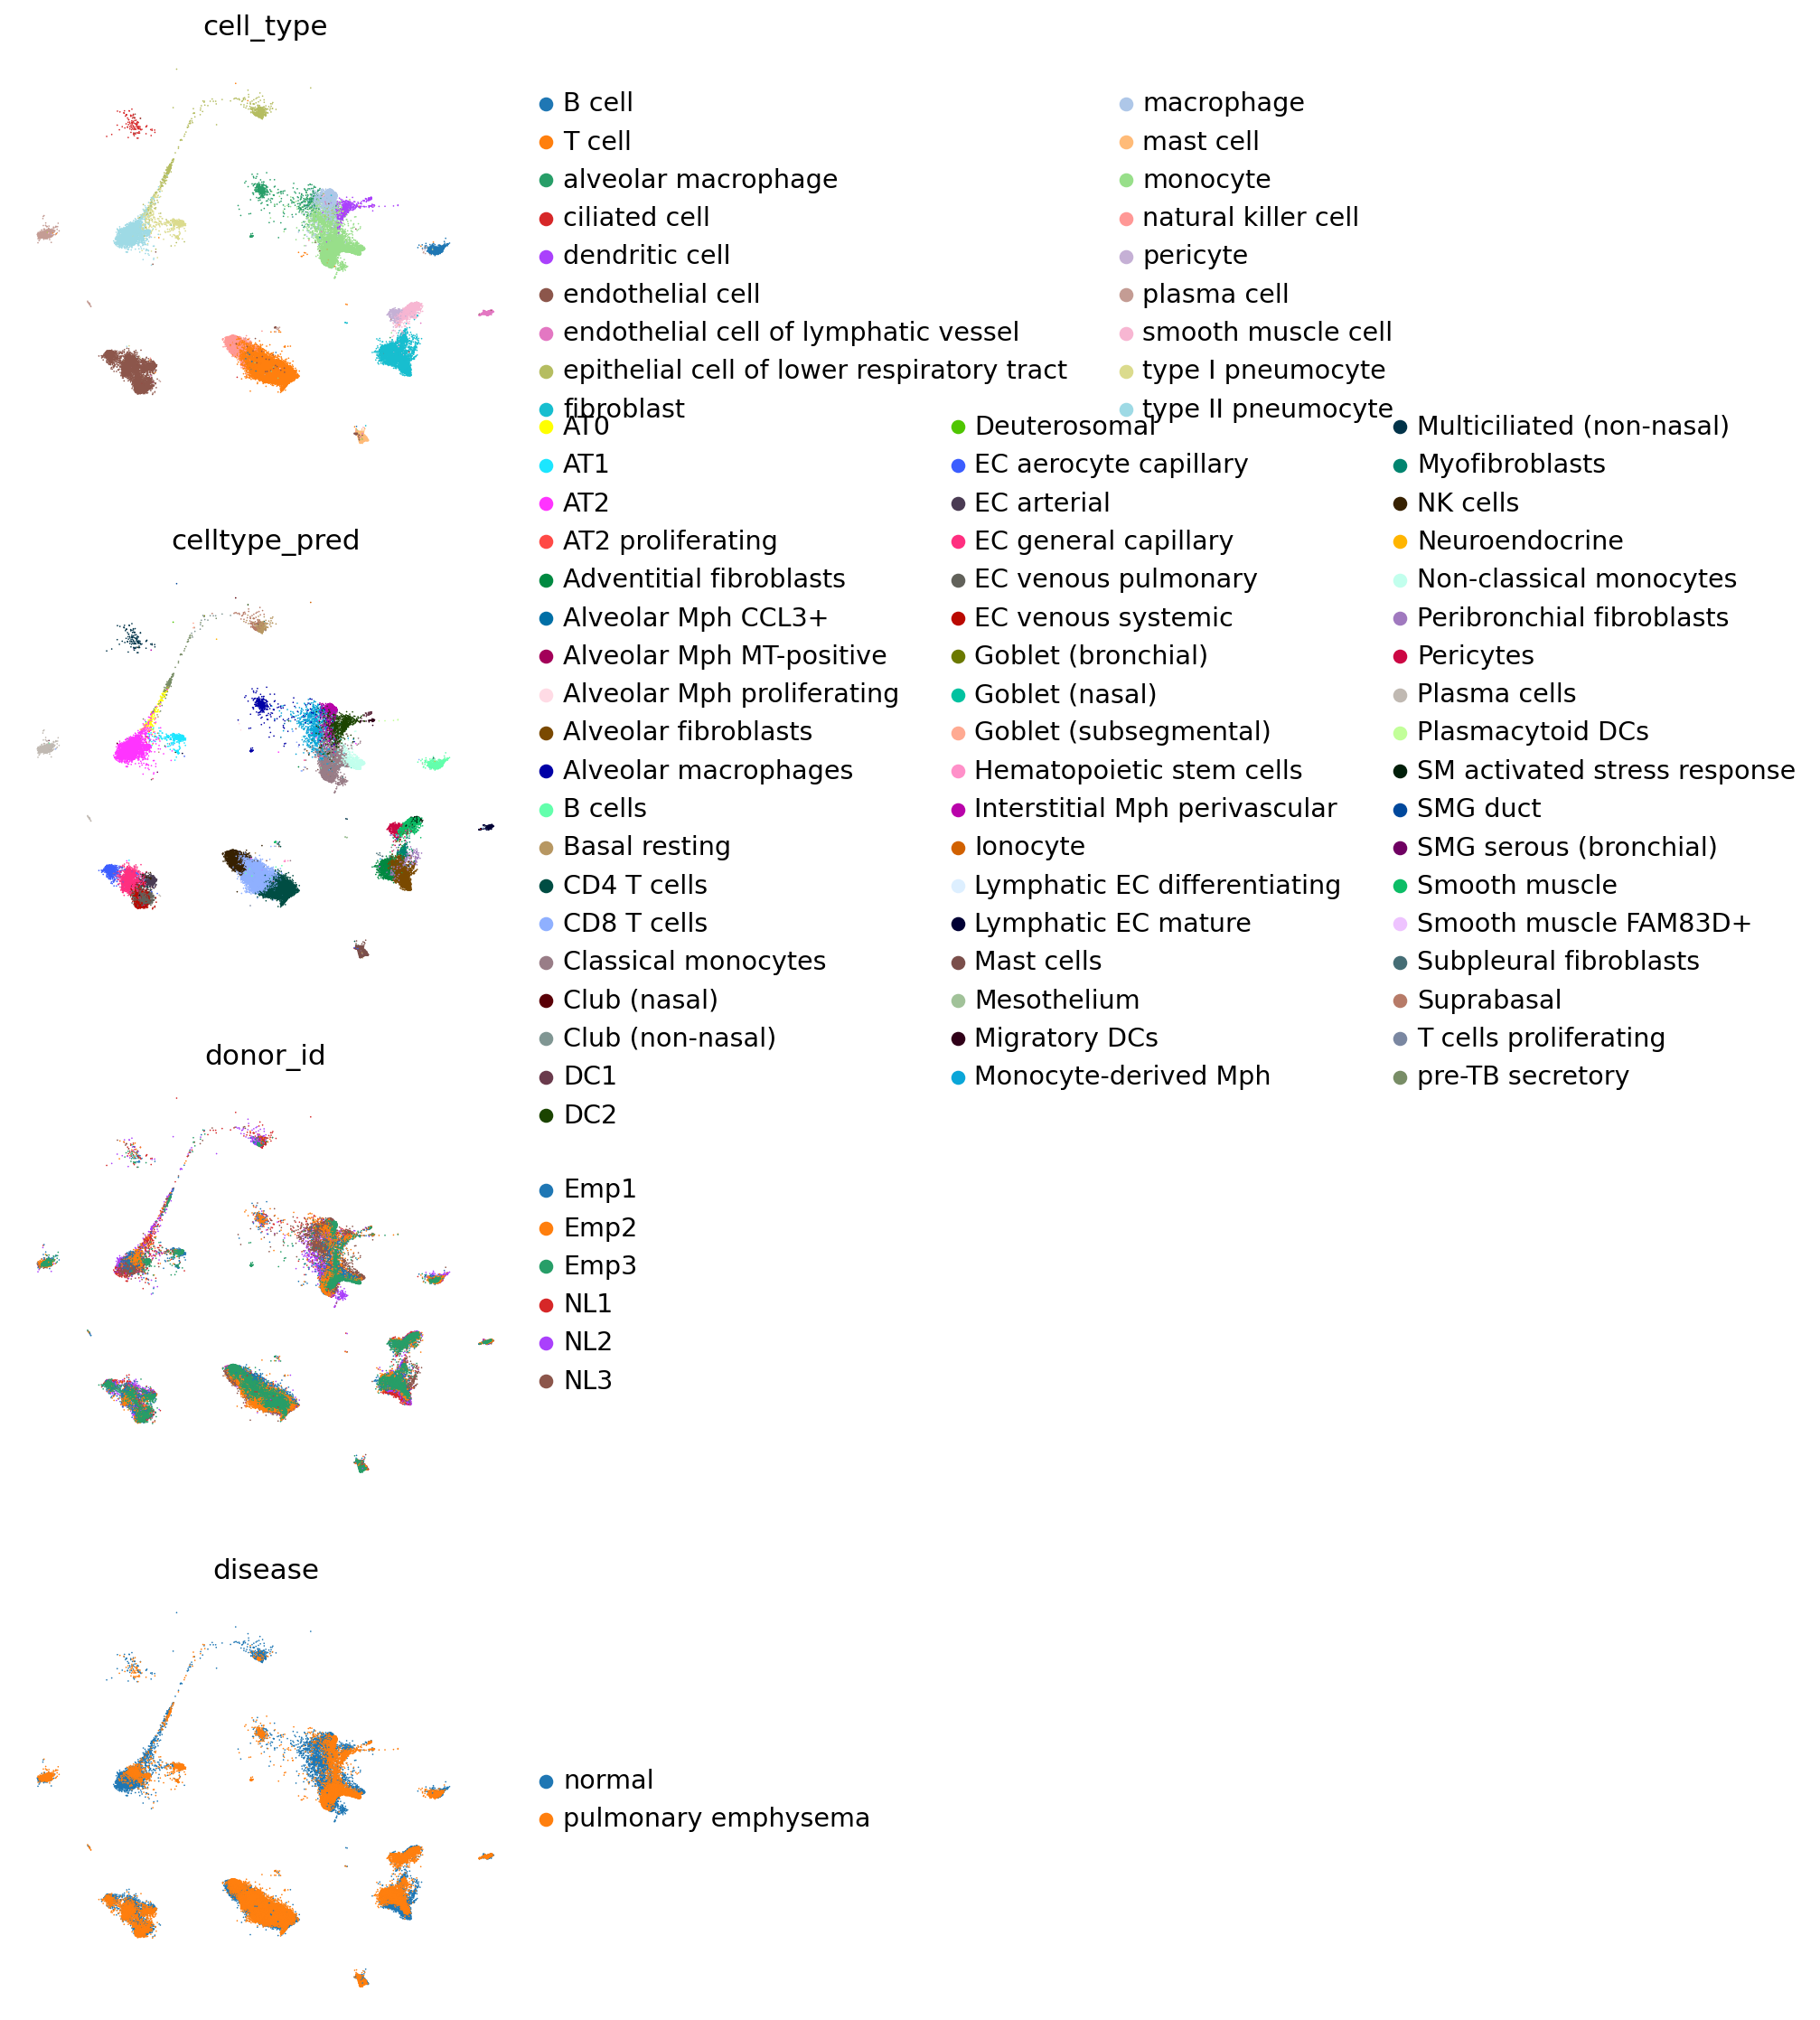

In [46]:
sc.pl.umap(
    combined_adata[combined_adata.obs["dataset"] == "emphysema"],
    color=["cell_type", "celltype_pred", "donor_id", "disease"],
    ncols=1,
    frameon=False,
)

In [47]:
pd.options.display.max_rows = 1000

In [12]:
combined_adata.obs["batch"] = "ref"
combined_adata.obs.loc[combined_adata.obs["dataset"] == "emphysema", "batch"] = "query"

In [49]:
combined_adata.obs['umap_size'] = 120000 / combined_adata.n_obs
combined_adata.obs.loc[combined_adata.obs["dataset"] == "emphysema", "umap_size"] = 120000 / combined_adata.n_obs * 30 # if you want to make the query dataset points bigger

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


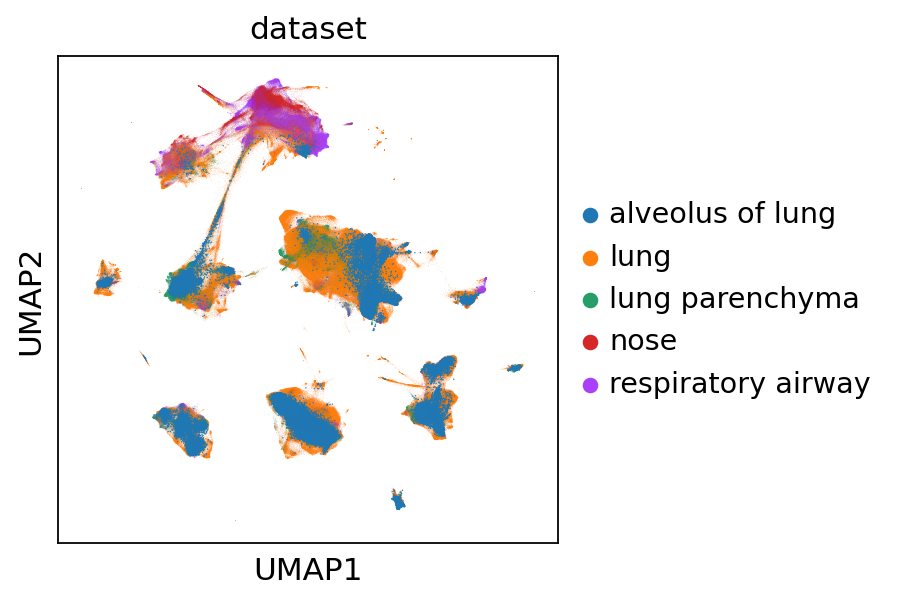

In [50]:
custom_pal = {"ref": "#EAE0DA", "query": "#DC0000"}
sc.pl.umap(
    combined_adata,
    color=["tissue"],
    ncols=1,
    size=combined_adata.obs['umap_size'].values,
    frameon=True,
    save="combined_umap_batch.pdf",
    #palette=custom_pal,
    title="dataset"
)

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


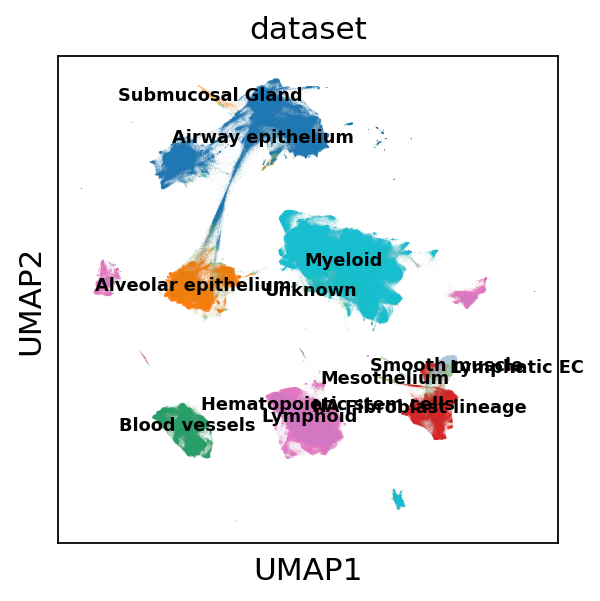

In [51]:
combined_adata.obs['lung_tissue'] = ['Lung' if 'lung' in i else 'Other' for i in combined_adata.obs['tissue']]
sc.pl.umap(
    combined_adata,
    color=["ann_level_2"],
    ncols=1,
    size=combined_adata.obs['umap_size'].values,
    frameon=True,
    save="combined_umap_celltype.pdf",
    title="dataset",
    legend_loc='on data',
    legend_fontsize=8
)

In [52]:
import milopy
import milopy.core as milo

In [53]:
combined_adata.obs[['batch', 'disease']].value_counts()

batch  disease                              
ref    normal                                   1305099
       COVID-19                                  341761
       pulmonary fibrosis                        268932
       interstitial lung disease                  68456
       chronic obstructive pulmonary disease      67943
       lung adenocarcinoma                        62807
       pneumonia                                  31923
query  pulmonary emphysema                        31792
ref    chronic rhinitis                           29137
query  normal                                     22293
ref    lung large cell carcinoma                  21167
       squamous cell lung carcinoma               20631
       cystic fibrosis                            17590
       lymphangioleiomyomatosis                   12374
       pleomorphic carcinoma                      10765
       hypersensitivity pneumonitis               10379
       non-specific interstitial pneumonia         8597
   

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from milopy_new.milopy import core as milo_new

In [56]:
combined_adata.obs['tissue_sampling_method'].value_counts()

donor_lung                  702873
lung_explant                428431
surgical_resection          292307
autopsy                     205374
balf                        202476
brush                       164056
biopsy                      100467
scraping                     82297
balf_cryopreserved           51689
donor_lung_cryopreserved     46500
autopsy_cryopreserved         4366
biopsy_cryopreserved          1611
Name: tissue_sampling_method, dtype: int64

In [57]:
combined_adata.obs['disease'].value_counts()

normal                                   1327392
COVID-19                                  341761
pulmonary fibrosis                        268932
interstitial lung disease                  68456
chronic obstructive pulmonary disease      67943
lung adenocarcinoma                        62807
pneumonia                                  31923
pulmonary emphysema                        31792
chronic rhinitis                           29137
lung large cell carcinoma                  21167
squamous cell lung carcinoma               20631
cystic fibrosis                            17590
lymphangioleiomyomatosis                   12374
pleomorphic carcinoma                      10765
hypersensitivity pneumonitis               10379
non-specific interstitial pneumonia         8597
pulmonary sarcoidosis                       4886
Name: disease, dtype: int64

In [58]:
query_adata = combined_adata[combined_adata.obs["batch"] == "query"].copy()

In [59]:
sc.pp.neighbors(combined_adata, n_neighbors=100, use_rep='X_scanvi_emb', method='rapids')
combined_adata.uns["neighbors"]["params"]["use_rep"]

'X_scanvi_emb'

In [60]:
milo_new.make_nhoods(combined_adata)
combined_adata.obsm["nhoods"]

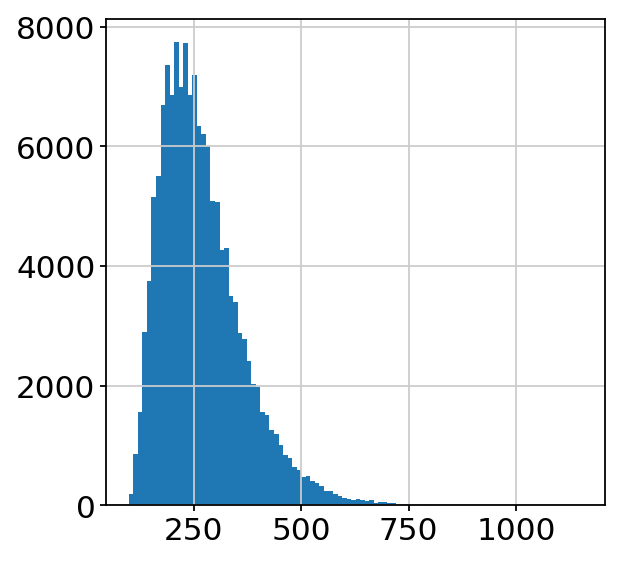

In [ ]:
nhood_size = np.array(combined_adata.obsm["nhoods"].sum(0)).ravel()
_ = plt.hist(nhood_size, bins=100)

/tmp/ipykernel_2016531/4020450925.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  healthy_adata.obs['donor_id'].cat.remove_unused_categories(inplace=True)
/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


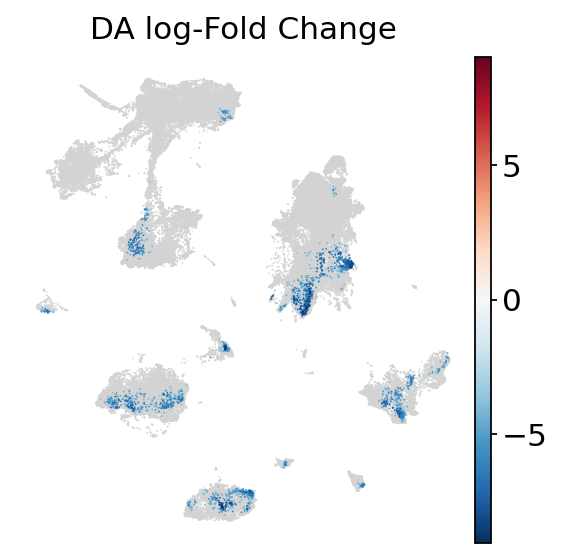

In [ ]:
healthy_adata = combined_adata[combined_adata.obs['disease']=='normal'].copy()
healthy_adata.obs['donor_id'].cat.remove_unused_categories(inplace=True)
sc.pp.neighbors(healthy_adata, n_neighbors=100, use_rep='X_scanvi_emb')
milo_new.make_nhoods(healthy_adata)
## Count cells from each sample in each nhood
milo_new.count_nhoods(healthy_adata, sample_col="donor_id")

## Test for differential abundance between conditions
milo_new.DA_nhoods(healthy_adata, design="~ batch")

## Check results
milo_results = healthy_adata.uns["nhood_adata"].obs
milopy.utils.build_nhood_graph(healthy_adata)
milopy.plot.plot_nhood_graph(healthy_adata, alpha=0.1, min_size=0.01)

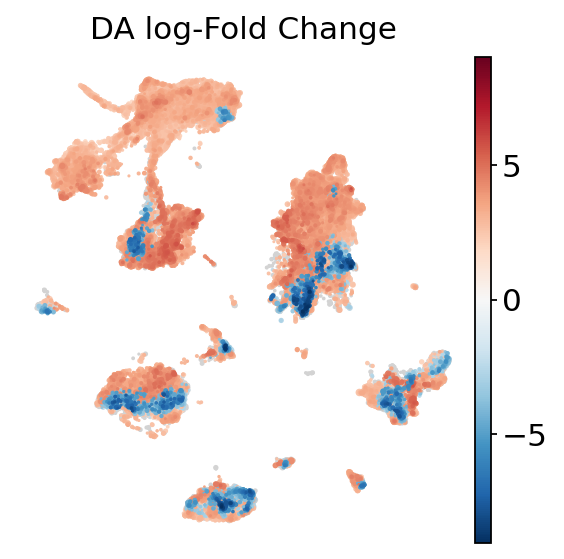

In [ ]:
milopy.plot.plot_nhood_graph(healthy_adata, alpha=0.2, min_size=0.05, save='healthy_emphysema_vs_hlca.pdf')

In [13]:
emphysema_adata = combined_adata[combined_adata.obs['batch']=='query'].copy()
emphysema_adata.obs['disease'].value_counts()

pulmonary emphysema    31792
normal                 22293
Name: disease, dtype: int64

In [14]:
emphysema_adata

AnnData object with n_obs × n_vars = 54085 × 1937
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 'ti

In [15]:
emphysema_adata = combined_adata[combined_adata.obs['batch']=='query'].copy()
emphysema_adata.obs['donor_id'].cat.remove_unused_categories(inplace=True)
sc.pp.neighbors(emphysema_adata, use_rep='X_scanvi_emb')
sc.tl.umap(emphysema_adata, min_dist=0.3)

/tmp/ipykernel_544571/1190510756.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  emphysema_adata.obs['donor_id'].cat.remove_unused_categories(inplace=True)


/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


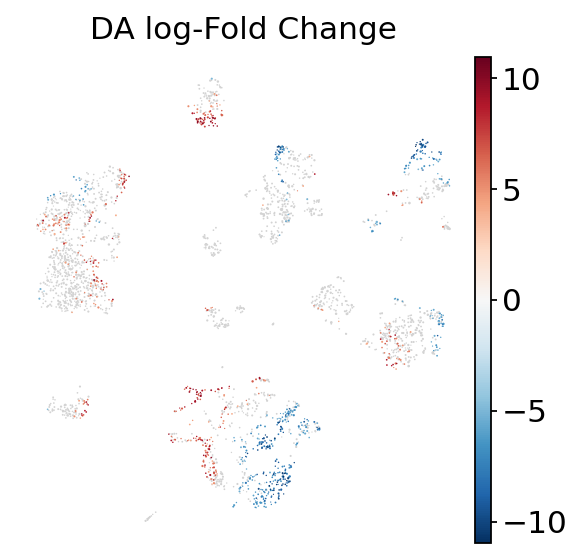

In [ ]:
sc.pp.neighbors(emphysema_adata, n_neighbors=100, use_rep='X_scanvi_emb', method='rapids')
milo_new.make_nhoods(emphysema_adata)
## Count cells from each sample in each nhood
milo_new.count_nhoods(emphysema_adata, sample_col="donor_id")

## Test for differential abundance between conditions
milo_new.DA_nhoods(emphysema_adata, design="~ disease")

## Check results
milo_results = emphysema_adata.uns["nhood_adata"].obs
milopy.utils.build_nhood_graph(emphysema_adata)
milopy.plot.plot_nhood_graph(emphysema_adata, alpha=0.1, min_size=0.01)

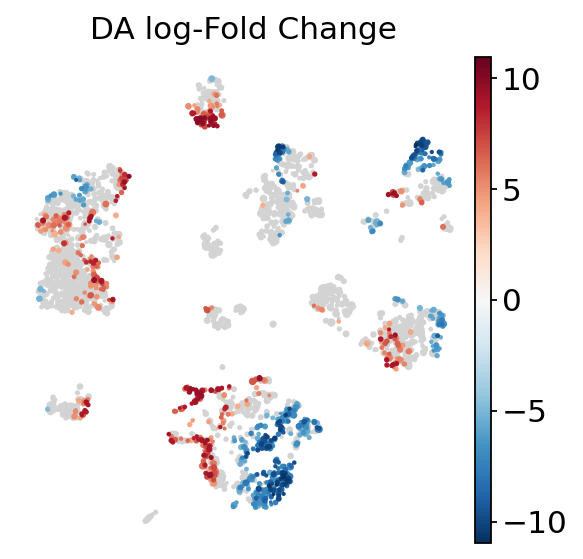

In [ ]:
milopy.plot.plot_nhood_graph(emphysema_adata, alpha=0.1, min_size=0.1, save='emphysema_vs_hlca.pdf')

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


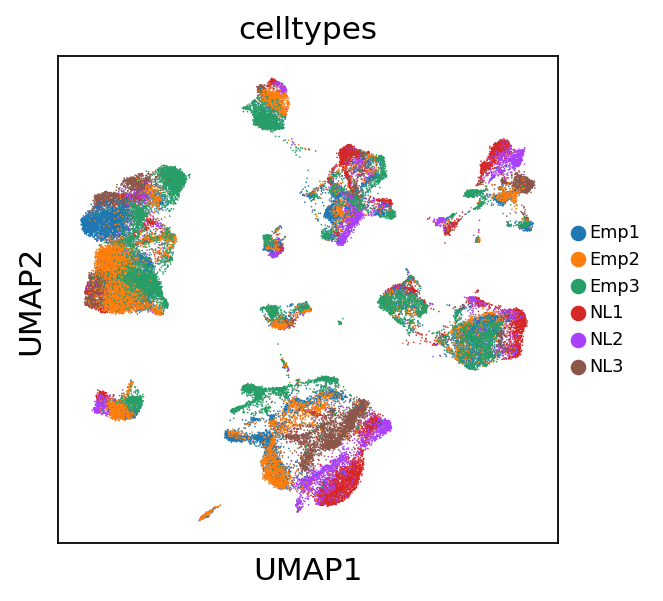

In [ ]:
sc.pl.umap(
    emphysema_adata,
    color=["donor_id"],
    ncols=1,
    frameon=True,
    title="celltypes",
    save="emphysema_umap_donors.pdf",
    legend_fontsize=8
)

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


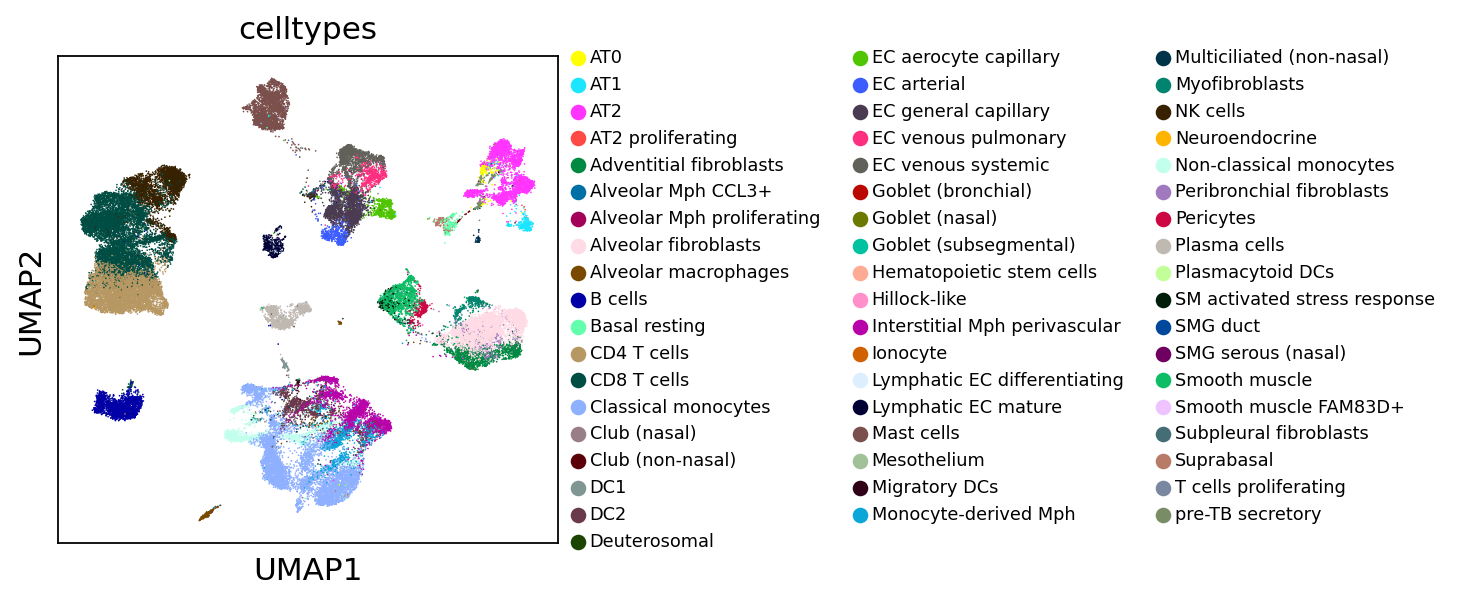

In [ ]:
sc.pl.umap(
    emphysema_adata,
    color=["celltype_pred"],
    ncols=1,
    frameon=True,
    save="emphysema_umap_celltypes.pdf",
    title="celltypes",
    legend_fontsize=8
)

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


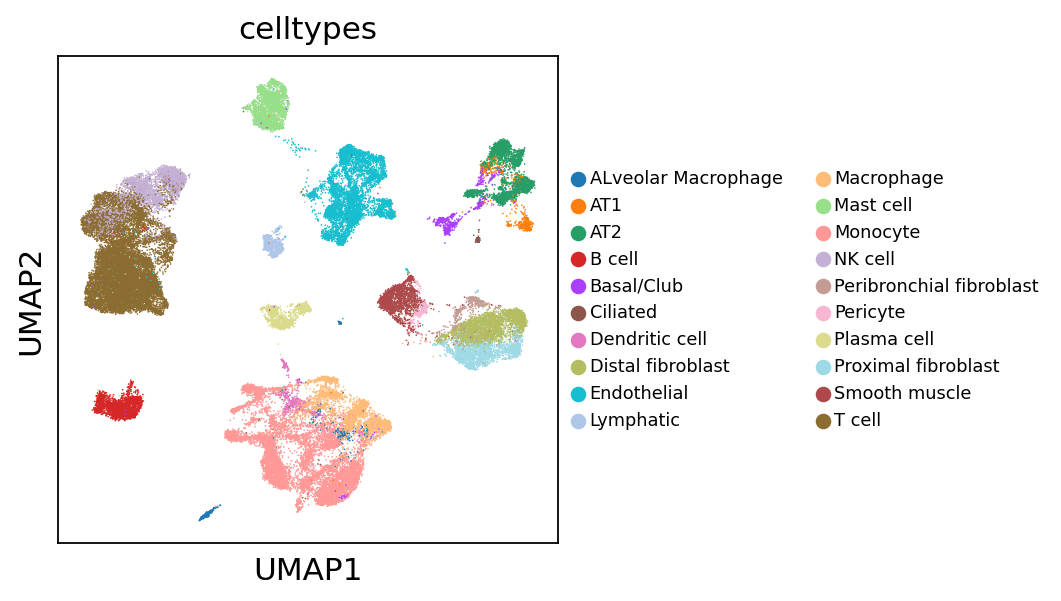

In [ ]:
sc.pl.umap(
    emphysema_adata,
    color=["celltype"],
    ncols=1,
    frameon=True,
    save="emphysema_umap_celltypes_original.pdf",
    title="celltypes",
    legend_fontsize=8
)

In [16]:
fibroblast_idx = emphysema_adata.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']) # ['Monocyte', 'Macrophage', 'Dendritic cell']) # 

fibroblast = emphysema_adata[fibroblast_idx].copy()

In [30]:
fibroblast.layers["normalized_counts"] = fibroblast.X.copy()
sc.pp.normalize_total(fibroblast, target_sum=1e4, layer="normalized_counts")
sc.pp.log1p(fibroblast, layer="normalized_counts")

In [45]:
fibroblast.var_names = fibroblast.var['feature_name-0']

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/anndata/_core/anndata.py:947: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A2M', 'ABCA1', 'ABCA3', 'ABCA6']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


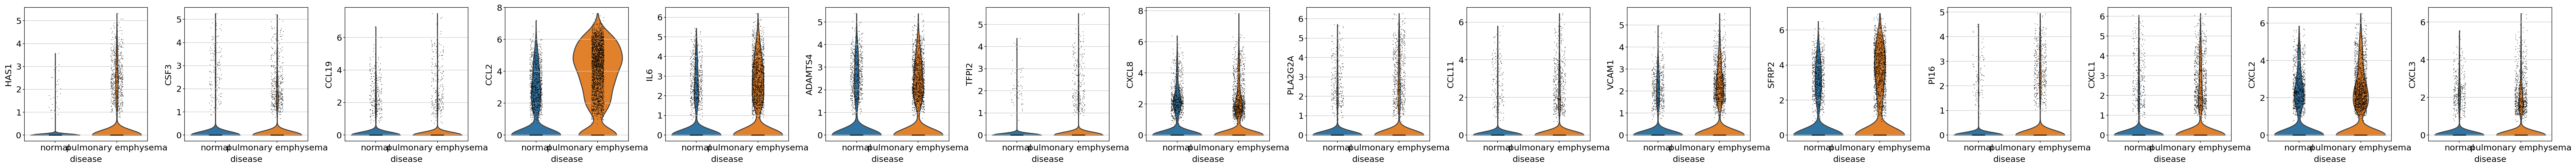

In [46]:
sc.pl.violin(
    fibroblast,
    gene_symbols='feature_name-0',
    keys=["HAS1", "CSF3", "CCL19", "CCL2", "IL6", "ADAMTS4", "TFPI2", "CXCL8", "PLA2G2A", "CCL11", "VCAM1", "SFRP2", "PI16", "CXCL1", "CXCL2", "CXCL3"],
    groupby="disease",
    save='emphysema_fibroblast_de_genes.pdf', layer="normalized_counts"
)

In [ ]:
sc.pl.umap(
    emphysema_adata,
    gene_symbols='feature_name-0',
    color=["HAS1", "CSF3", "CCL19", "CCL2", "IL6", "ADAMTS4", "TFPI2", "CXCL8", "PLA2G2A", "CCL11", "VCAM1", "SFRP2", "PI16", "CXCL1", "CXCL2", "CXCL3"],
    ncols=4,
    frameon=True,
    legend_fontsize=8,
    vmax='p99',
    size=3,
    save='emphysema_fibroblast_de_genes.pdf'
)

In [51]:
2

2

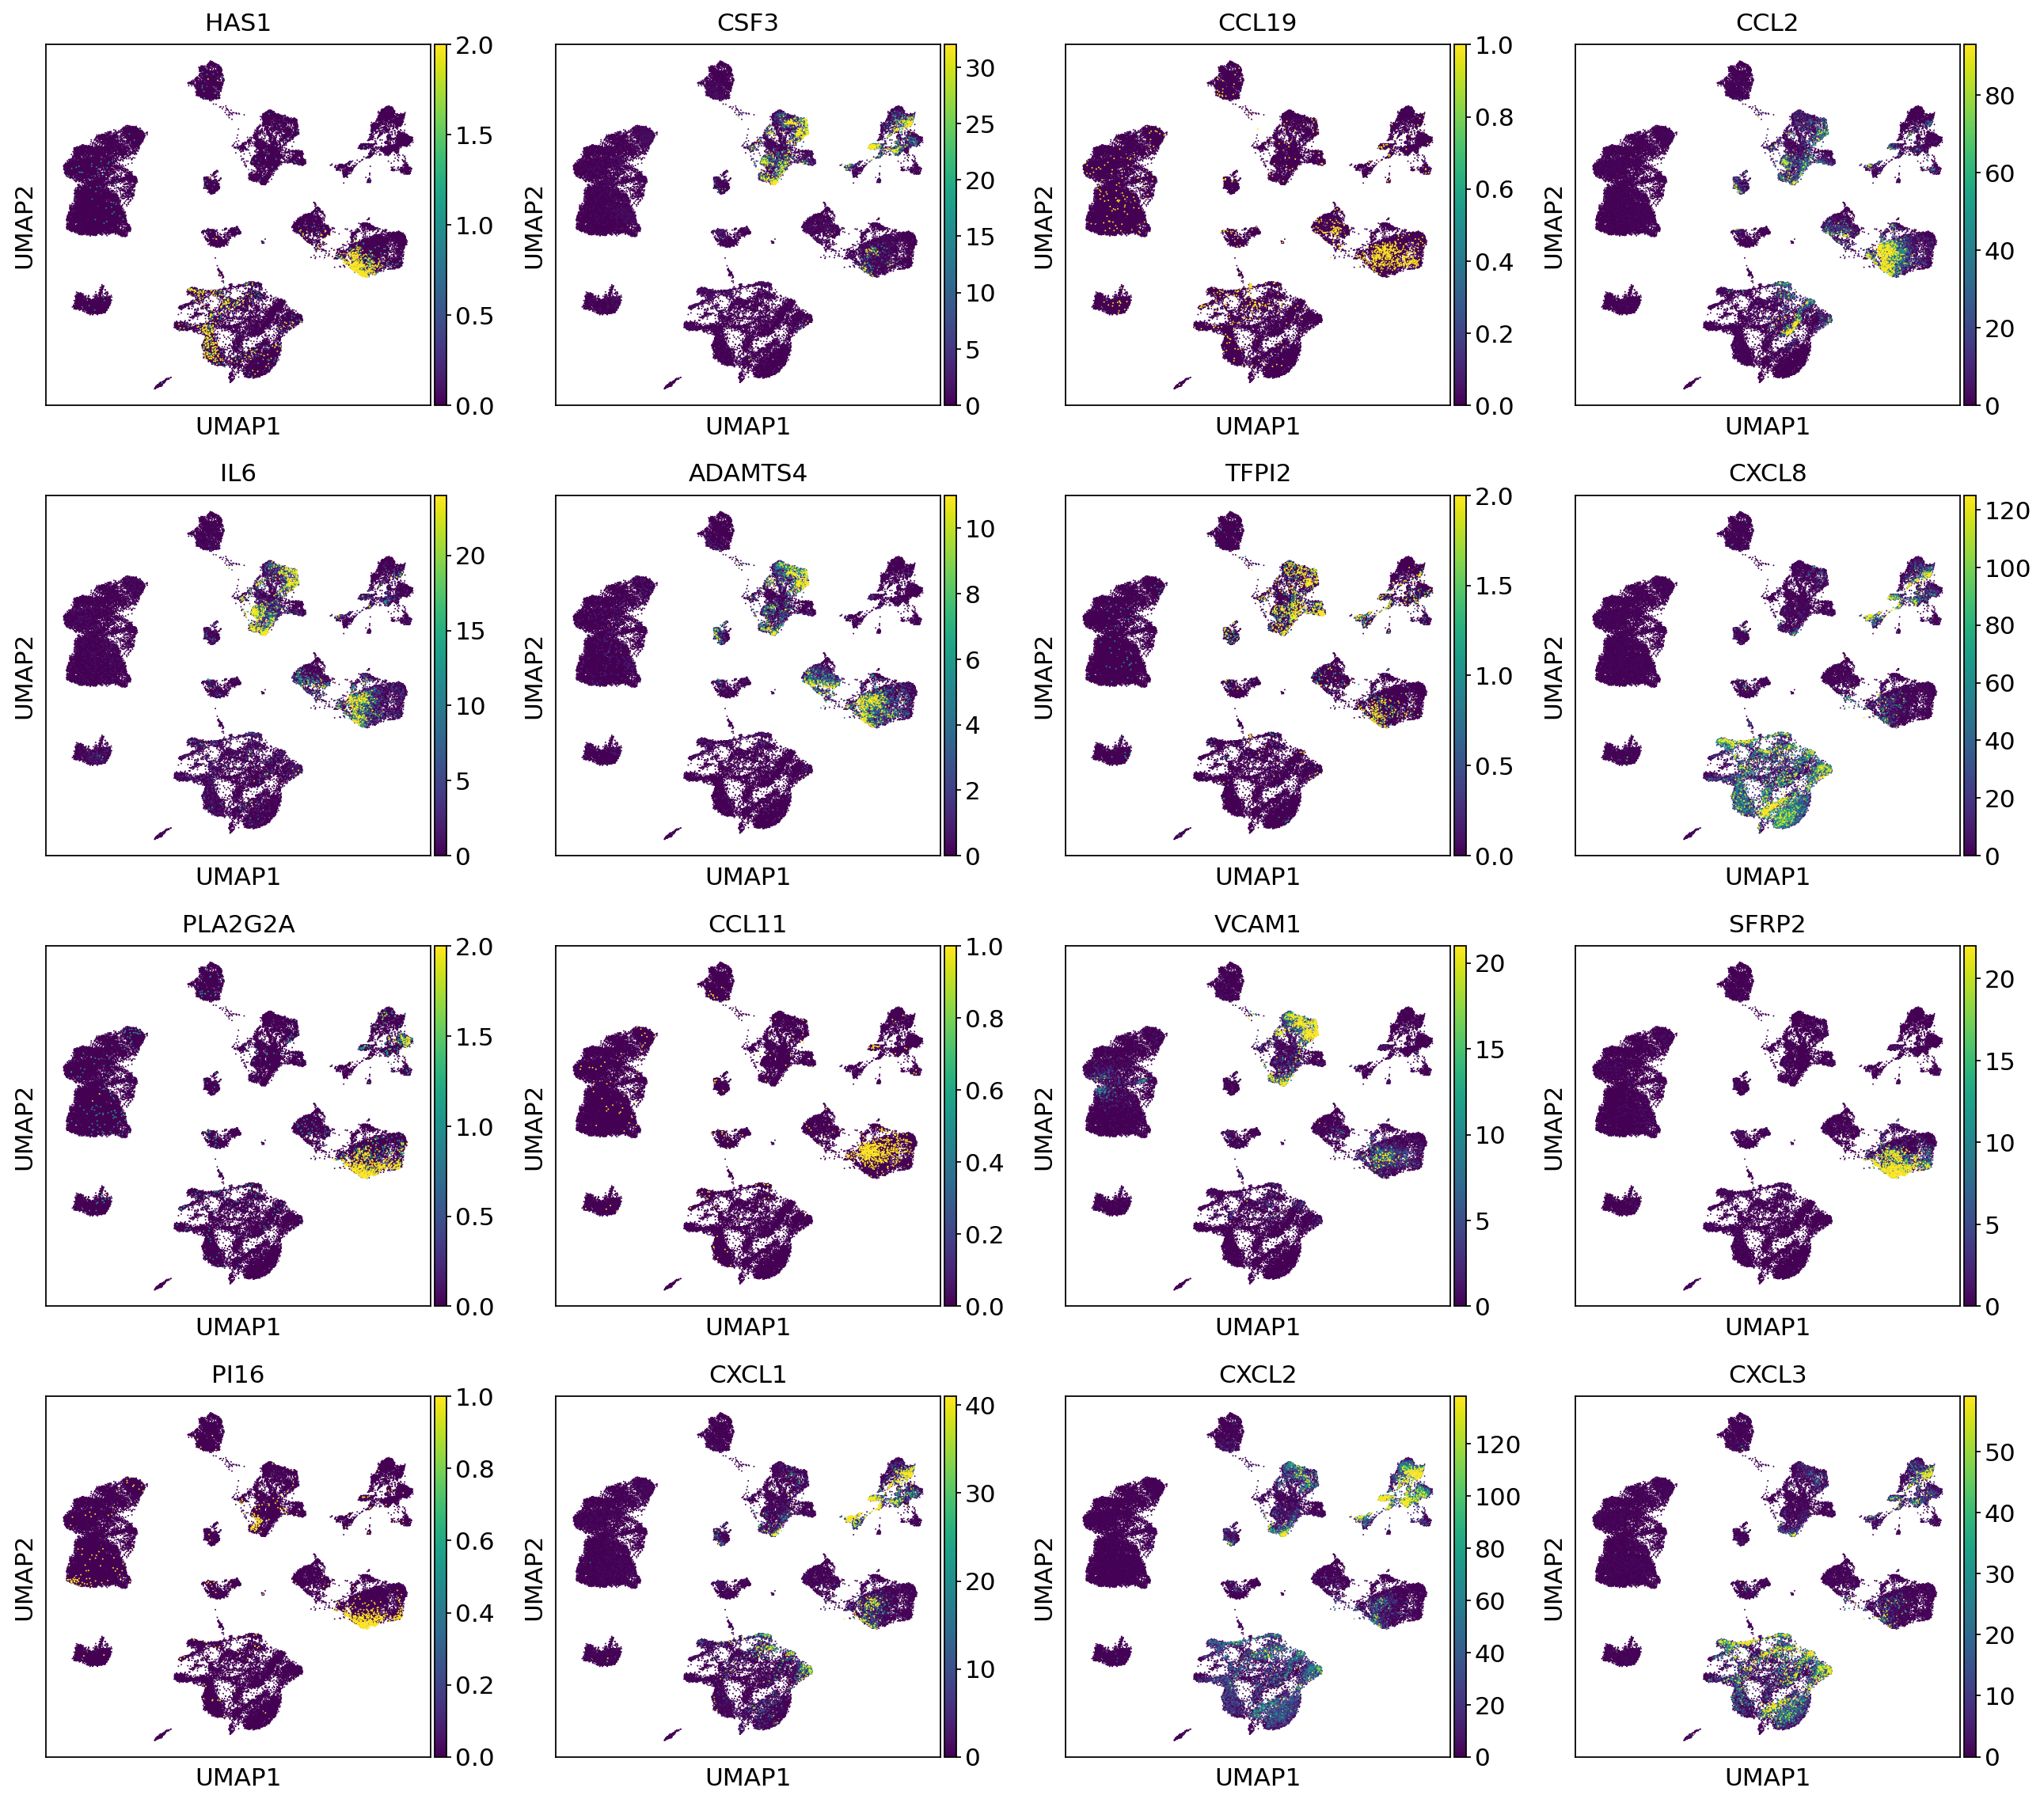

In [ ]:
sc.pl.umap(
    emphysema_adata,
    gene_symbols='feature_name-0',
    color=["HAS1", "CSF3", "CCL19", "CCL2", "IL6", "ADAMTS4", "TFPI2", "CXCL8", "PLA2G2A", "CCL11", "VCAM1", "SFRP2", "PI16", "CXCL1", "CXCL2", "CXCL3"],
    ncols=4,
    frameon=True,
    legend_fontsize=8,
    vmax='p99',
    size=3,
    save='emphysema_fibroblast_de_genes.pdf'
)

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


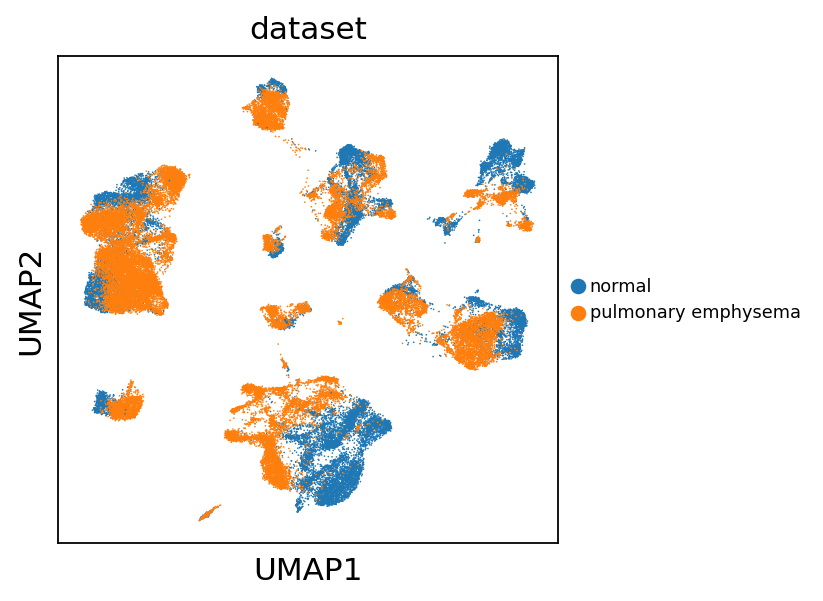

In [ ]:
sc.pl.umap(
    emphysema_adata,
    color=["disease"],
    ncols=1,
    frameon=True,
    save="emphysema_umap_disease.pdf",
    title="dataset",
    legend_fontsize=8
)

In [52]:
fibroblast_idx = emphysema_adata.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']) # ['Monocyte', 'Macrophage', 'Dendritic cell']) # 

fibroblast = emphysema_adata[fibroblast_idx].copy()
cell_idx1 = fibroblast.obs["disease"] == 'pulmonary emphysema'
cell_idx2 = fibroblast.obs["disease"] == 'normal'

In [53]:
scvi.model.SCANVI.prepare_query_anndata(fibroblast, local_dir)
query_save_path = f"{local_dir}/query_model"
query_fibroblast = scvi.model.SCANVI.load(query_save_path, adata=fibroblast)

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/scvi-hub-reproducibility/model.pt already downloaded      
INFO     Found 96.85000000000001% reference vars in query data.                                                    
INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/scvi-hub-reproducibility/query_model/model.pt already     
         downloaded                                                                                                


/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [54]:
de_change = query_fibroblast.differential_expression(idx1=cell_idx1, idx2=cell_idx2, batch_correction=True, filter_outlier_cells=True)
de_change.index = [fibroblast.var.loc[i, 'feature_name-0'] for i in de_change.index]
de_change[de_change[['non_zeros_proportion1', 'non_zeros_proportion2']].max(1)>0.05].head(50)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


DE...: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
HAS1       0.956757      0.043243      3.096708  0.000306  0.000035   
CXCL8      0.949349      0.050651      2.930825  0.000932  0.000320   
CSF3       0.949149      0.050851      2.926669  0.000149  0.000040   
CXCL1      0.945546      0.054454      2.854397  0.001214  0.000458   
CCL19      0.945145      0.054855      2.846648  0.000901  0.000344   
CCL2       0.944745      0.055255      2.838951  0.015156  0.005045   
IL6        0.943343      0.056657      2.812421  0.001561  0.000673   
ADAMTS4    0.941141      0.058859      2.771951  0.000767  0.000236   
CCL11      0.939139      0.060861      2.736373  0.001677  0.000729   
PLA2G2A    0.938939      0.061061      2.732876  0.001505  0.000865   
CXCL2      0.936537      0.063463      2.691724  0.001706  0.000771   
TFPI2      0.935736      0.064264      2.678329  0.000152  0.000045   
LIF        0.934134      0.065866      2.652000  0.000138  0.000042   
AREG       0.933934      0.066066      2.648750  0.000506  0.000225   
CCL20      0.932733      0.067267      2.629445  0.000172  0.000072   
SFRP2      0.931732      0.068268      2.613600  0.004216  0.002844   
MT1G       0.928929      0.071071      2.570352  0.000343  0.000314   
MT1A       0.928929      0.071071      2.570352  0.001270  0.000763   
PLAUR      0.927327      0.072673      2.546341  0.000779  0.000283   
LUCAT1     0.926927      0.073073      2.540415  0.000031  0.000012   
CXCL3      0.925926      0.074074      2.525729  0.000425  0.000196   
VCAM1      0.925526      0.074474      2.519905  0.000439  0.000183   
MFAP5      0.925325      0.074675      2.517004  0.000434  0.000157   
PI16       0.924925      0.075075      2.511224  0.000331  0.000083   
NR4A3      0.923323      0.076677      2.488382  0.000347  0.000152   
SERPINE2   0.922523      0.077477      2.477124  0.000875  0.000401   
PPP1R14A   0.920320      0.079680      2.446707  0.001762  0.002175   
FGFR4      0.919920      0.080080      2.441259  0.000499  0.000685   
TNFRSF12A  0.919319      0.080681      2.433134  0.001457  0.000563   
PRKCB      0.919119      0.080881      2.430438  0.000052  0.000066   
RPS4Y1     0.918719      0.081281      2.425064  0.000759  0.001896   
HIF3A      0.918318      0.081682      2.419714  0.000257  0.000554   
TNFAIP6    0.917918      0.082082      2.414388  0.000909  0.000414   
LPL        0.916116      0.083884      2.390710  0.000312  0.000436   
ICAM1      0.915516      0.084484      2.382919  0.001348  0.000673   
IGF2       0.915115      0.084885      2.377754  0.000100  0.000069   
PHLDA2     0.915115      0.084885      2.377754  0.000252  0.000135   
HAS2       0.914915      0.085085      2.375179  0.000636  0.000265   
EGR3       0.914715      0.085285      2.372610  0.000220  0.000126   
THY1       0.914715      0.085285      2.372610  0.000491  0.000233   
TNFAIP3    0.914114      0.085886      2.364936  0.000700  0.000320   
RAMP2      0.913113      0.086887      2.352253  0.000107  0.000106   
CCL4L2     0.912312      0.087688      2.342201  0.000051  0.000023   
EREG       0.912312      0.087688      2.342201  0.000047  0.000018   
GZMB       0.911712      0.088288      2.334716  0.000028  0.000007   
CASS4      0.911111      0.088889      2.327278  0.000165  0.000164   
PTX3       0.910511      0.089489      2.319884  0.001634  0.000654   
ANGPT1     0.909910      0.090090      2.312535  0.000797  0.001277   
IL1B       0.908509      0.091491      2.295558  0.000052  0.000022   
MYOC       0.908108      0.091892      2.290751  0.000232  0.000247   

           pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
HAS1                0.0   0.25  2.644535    2.640604  3.647406  -8.442909   
CXCL8               0.0   0.25  1.722912    1.882632  2.508782  -7.031967   
CSF3                0.0   0.25  2.250046    2.415077  3.712005 -10.870293   
CXCL1               0.0   0.25  1.663924    1.790275  2.620437  -7.922364   
CCL1

In [55]:
de_change = de_change[de_change[['non_zeros_proportion1', 'non_zeros_proportion2']].max(1)>0.05]
de_change['padj'] = - np.log10(de_change['proba_not_de'])

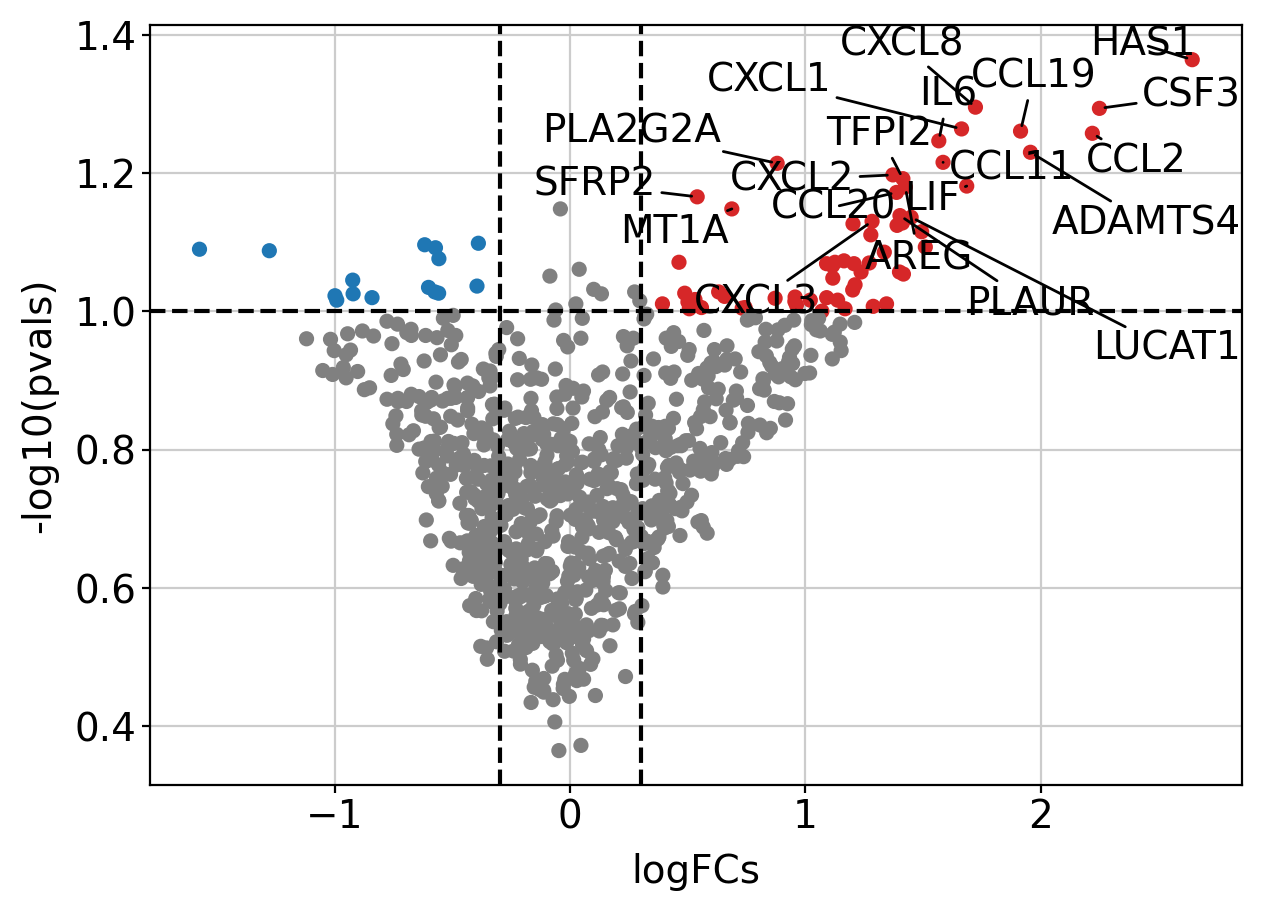

In [57]:
import decoupler as dc

dc.plot_volcano_df(de_change, x='lfc_mean', y='proba_not_de', top=20, sign_thr=0.1, lFCs_thr=0.3, lFCs_limit=3)
plt.savefig('fibroblast_emphysema_scvi.pdf')
plt.show()

In [ ]:
fibroblast_idx = query_data.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']) # 'Monocyte', 'Macrophage', 'Dendritic cell'

fibroblast = query_data[fibroblast_idx].copy()
fibroblast.var.index = fibroblast.var['feature_name']

In [ ]:
query_data.obs["celltype"]

index
AAACCCAAGCGTTCAT-1_1                 T cell
AAACCCAGTCCTCCAT-1_1                 T cell
AAACCCAGTCGCATGC-1_1               Monocyte
AAACCCATCAAACGTC-1_1                 T cell
AAACGAAAGCACGATG-1_1               Monocyte
                               ...         
TTTGGTTGTACGTGAG-1_6    Proximal fibroblast
TTTGGTTGTAGCTCGC-1_6                    AT2
TTTGGTTTCTATACGG-1_6               Pericyte
TTTGTTGAGAGCAACC-1_6      Distal fibroblast
TTTGTTGCACTTGGCG-1_6            Endothelial
Name: celltype, Length: 54085, dtype: category
Categories (20, object): ['ALveolar Macrophage', 'AT1', 'AT2', 'B cell', ..., 'Plasma cell', 'Proximal fibroblast', 'Smooth muscle', 'T cell']

In [ ]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    fibroblast,
    sample_col='donor_id',
    groups_col=None,
    mode='sum',
    min_cells=10,
    min_counts=1000,
)
pdata

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 6 × 22162
    obs: 'donor_id', 'organism_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'compartment', 'dataset', 'psbulk_n_cells', 'psbulk_counts'
    var: 'name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

In [ ]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(pdata, group='disease', min_count=5, min_total_count=15)

# Filter by these genes
pdatas = pdata[:, genes].copy()

In [ ]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [ ]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=pdatas,
    design_factors=['disease'],
    ref_level=['disease', 'normal'],
    refit_cooks=True,
)

In [ ]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.58 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 3.42 seconds.

Fitting LFCs...
... done in 0.63 seconds.

Refitting 0 outliers.



In [ ]:
stat_res = DeseqStats(dds)

In [ ]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: disease pulmonary emphysema vs normal
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                               
A1BG            216.957321       -0.353514  0.385203 -0.917734  0.358758   
A1BG-AS1         23.106413       -0.018624  0.283279 -0.065745  0.947581   
A2M           42808.636719       -0.125538  0.137002 -0.916325  0.359496   
A2M-AS1          11.499570       -0.242156  0.364039 -0.665192  0.505928   
A4GALT          292.838898       -0.181378  0.260277 -0.696867  0.485886   
...                    ...             ...       ...       ...       ...   
ZYG11B          275.965729       -0.327976  0.090425 -3.627069  0.000287   
ZYX            1451.990112        0.264228  0.104844  2.520204  0.011729   
ZZEF1           196.041199       -0.071926  0.210732 -0.341317  0.732865   
ZZZ3            267.716248       -0.143346  0.170491 -0.840779  0.400472   
bP-21264C1.2

... done in 0.49 seconds.



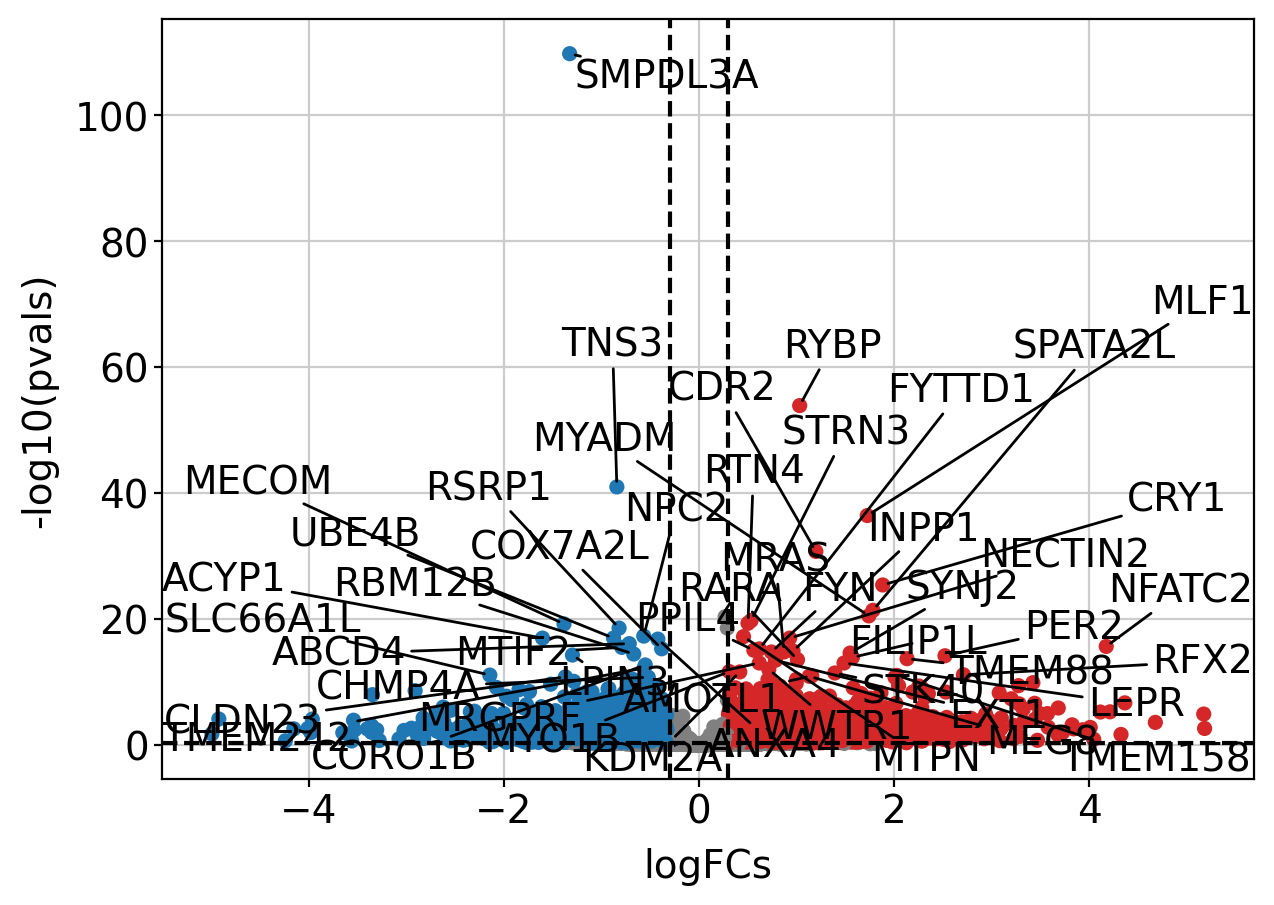

In [ ]:
results_df = stat_res.results_df
dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=50, sign_thr=0.5, lFCs_thr=0.3, lFCs_limit=12)
plt.savefig('fibroblast_emphysema.svg')
plt.show()

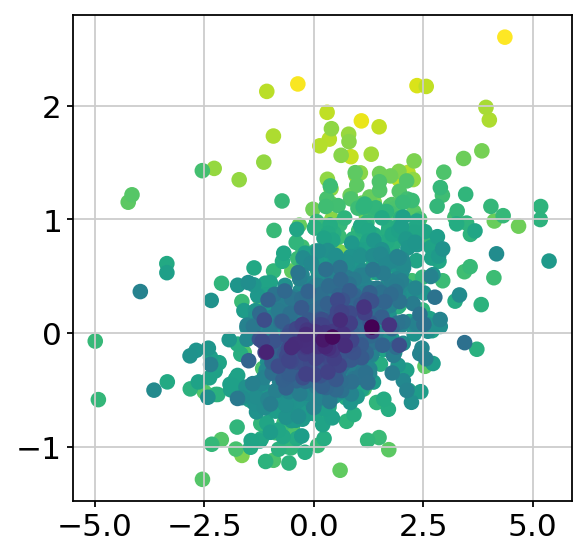

In [ ]:
de_change['LFC_pseudobulk'] = results_df['log2FoldChange']
significant_de = de_change[de_change['bayes_factor']>2]
plt.scatter(de_change['LFC_pseudobulk'], de_change['lfc_mean'], c=de_change['bayes_factor'])

In [ ]:
significant_de.loc['CXCL2']

proba_de                  0.931932
proba_not_de              0.068068
bayes_factor              2.616751
scale1                    0.001666
scale2                    0.000793
pseudocounts                   0.0
delta                         0.25
lfc_mean                   1.35156
lfc_median                1.435228
lfc_std                    2.30759
lfc_min                  -7.579103
lfc_max                   8.560024
raw_mean1                 3.997123
raw_mean2                  2.67512
non_zeros_proportion1     0.487212
non_zeros_proportion2     0.365544
raw_normalized_mean1     15.346596
raw_normalized_mean2      8.961107
is_de_fdr_0.05               False
LFC_pseudobulk             0.31237
Name: CXCL2, dtype: object

In [ ]:
emphysema_adata

AnnData object with n_obs × n_vars = 54085 × 1937
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 'ti

## DEBUGGING

In [ ]:
import gc
import anndata
p1 = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/old/data_stuff/HLCA/hlca_new/HLCA_emb_and_metadata.h5ad"
p2 = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref_old/temp_manual_backup/HLCA_full_v1.1_emb.h5ad"
adata1 = anndata.read_h5ad(p1)
t = anndata.read_h5ad(p2)
adata2 = t[t.obs["core_or_extension"] == "core"].copy()
del t
gc.collect()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/old/data_stuff/HLCA/hlca_new/HLCA_emb_and_metadata.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
idx_diff = adata2.obs.index.difference(adata1.obs.index)
idx_common = adata2.obs.index.difference(idx_diff)
ann_1 = adata1.obs.loc[idx_common]["ann_level_3"].astype("str")
ann_2 = adata2.obs.loc[idx_common]["ann_level_3"].astype("str")
ann_1.name = "ann_1"
ann_2.name = "ann_2"
df = pd.concat([ann_1, ann_2], axis=1)
df["ann_1,ann_2"] = df["ann_1"] + "," + df["ann_2"]

In [ ]:
df[ann_1 != ann_2]["ann_1,ann_2"].value_counts()
# in 2 not in 1: 'Smooth muscle FAM83D+',
# in 1 not in 2: 'Fibromyocytes',

Fibromyocytes,Smooth muscle FAM83D+    335
Secretory,AT2                          230
Name: ann_1,ann_2, dtype: int64

In [ ]:
i = query_emb.obs["celltype_pred"] == "SM activated stress response"
query_emb.obs.loc[i, ["celltype_pred", "celltype_uncertainty"]]

celltype_pred  celltype_uncertainty
GAGACTTCAAGACCTT  SM activated stress response               0.30005

In [ ]:
query_emb.obs

celltype_pred  celltype_uncertainty
AAGCGTTTCAGTGCGC           Lymphatic EC mature              0.399993
AGCCACGAGGAGTCTG           Lymphatic EC mature              0.400029
ATCATTCGTATTTCGG  Lymphatic EC differentiating              0.200081
TGGCGTGCATGTAACC           Lymphatic EC mature              0.099992
CTACAGACACTGTGAT                     EC venous              0.000000
...                                        ...                   ...
TGATGCACATGGGCAA                           AT1              0.000000
AATGACCAGCCGATTT                T cell lineage              0.000000
CTCCATGCACTCTAGA                   Fibroblasts              0.000000
ATGGGTTAGAGGCGTT                           AT1              0.200000
CGTGTCTCACGCTGTG                     EC venous              0.499982

[1786 rows x 2 columns]

In [ ]:
metadata["predicted_celltype"].value_counts()

myofibroblast            1031
vascular endothelial      415
lymphatic endothelial      97
AT1                        62
CD8+ T cell                57
pericyte                   28
club                       12
smc                        12
macrophage                 10
nkt                         8
fibroblast                  8
CD4+ T cell                 7
neutrophil                  7
plasma cell                 7
mast                        6
NK cell                     4
Treg                        3
B cell                      2
cDC                         2
AT2                         2
Name: predicted_celltype, dtype: int64

In [ ]:
metadata["predicted_celltype"]

AAGCGTTTCAGTGCGC    lymphatic endothelial
AGCCACGAGGAGTCTG    lymphatic endothelial
ATCATTCGTATTTCGG    lymphatic endothelial
TGGCGTGCATGTAACC    lymphatic endothelial
CTACAGACACTGTGAT    lymphatic endothelial
                            ...          
TGATGCACATGGGCAA                      NaN
AATGACCAGCCGATTT                      NaN
CTCCATGCACTCTAGA                      NaN
ATGGGTTAGAGGCGTT                      NaN
CGTGTCTCACGCTGTG                      NaN
Name: predicted_celltype, Length: 1786, dtype: object

In [ ]:
dddd = pd.DataFrame(index=metadata["predicted_celltype"].index, columns=["pred", "ground_truth", "pred_uncertainty"])
dddd["pred"] = query_emb.obs["celltype_pred"]
dddd["pred_uncertainty"] = query_emb.obs["celltype_uncertainty"]
dddd["ground_truth"] = metadata["predicted_celltype"].fillna("Unknown")

In [ ]:
# dddd[dddd["ground_truth"] == "pericyte"]["pred"].value_counts()
dddd[dddd["pred"] == "Fibroblasts"]["ground_truth"].value_counts()

myofibroblast           1029
pericyte                  28
fibroblast                 8
smc                        5
vascular endothelial       3
club                       3
Unknown                    1
Name: ground_truth, dtype: int64

In [ ]:
10 / 23

0.43478260869565216